In [1]:
# ============================================================
# 01_exploration.ipynb
# METABONET EDA — Glucose Foundation Model
# ============================================================

In [2]:
# Cell 1 — Setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import pyarrow.parquet as pq
from collections import defaultdict
import polars as pl
from pathlib import Path

os.chdir('/mnt/workspace/tvae')

# Plot style
plt.rcParams.update({
    'figure.dpi'      : 150,
    'axes.spines.top' : False,
    'axes.spines.right': False,
    'font.size'       : 10,
})

# Clinical thresholds
CGM_MIN, CGM_MAX    = 40, 400
HYPO_THRESHOLD      = 70
HYPER_THRESHOLD     = 180
TARGET_LOW, TARGET_HIGH = 70, 140

print("Setup complete")
print(f"Working directory: {os.getcwd()}")

Setup complete
Working directory: /mnt/workspace/tvae


In [3]:
# Cell 2 — Dataset overview (metadata only, no data loaded)
f_train = pq.ParquetFile('raw_data/metabonet_train_filtered.parquet')

print("METABONET — Dataset Overview")
print(f"{'─'*50}")
print(f"Filtered file (831 patients with ≥10 bolus + ≥10 carbs events):")
print(f"  Rows       : {f_train.metadata.num_rows:,}")
print(f"  Row groups : {f_train.metadata.num_row_groups}")
print(f"  Columns    : {[f_train.schema_arrow.field(i).name for i in range(f_train.metadata.num_columns)]}")
print(f"\nNote: heartrate excluded from EDA — low coverage, not used in model design")
print(f"\nEstimated monitoring time:")
print(f"  Total patient-days : {f_train.metadata.num_rows/288:,.0f}")
print(f"  Mean per patient   : {f_train.metadata.num_rows/288/831:,.0f} days (~{f_train.metadata.num_rows/288/831/30:.0f} months)")

METABONET — Dataset Overview
──────────────────────────────────────────────────
Filtered file (831 patients with ≥10 bolus + ≥10 carbs events):
  Rows       : 121,388,404
  Row groups : 249
  Columns    : ['id', 'date', 'CGM', 'bolus', 'basal', 'carbs', 'insulin', 'heartrate', 'age', 'gender', 'age_of_diagnosis', 'insulin_delivery_modality']

Note: heartrate excluded from EDA — low coverage, not used in model design

Estimated monitoring time:
  Total patient-days : 421,488
  Mean per patient   : 507 days (~17 months)


In [4]:
# Cell 3 — Global statistics (streaming)
f = pq.ParquetFile('raw_data/metabonet_train_filtered.parquet')

stats = {
    'total_rows'   : 0,
    'patients'     : set(),
    'cgm_missing'  : 0,
    'cgm_count'    : 0,
    'cgm_sum'      : 0.0,
    'cgm_sum_sq'   : 0.0,
    'bolus_events' : 0,
    'carbs_events' : 0,
    'basal_events' : 0,
    'insulin_events': 0,
}

cgm_bins  = np.zeros(73, dtype=np.int64)
cgm_edges = np.linspace(40, 400, 74)

for batch in f.iter_batches(batch_size=1_000_000):
    df = batch.to_pandas()

    stats['total_rows'] += len(df)
    stats['patients'].update(df['id'].unique())

    cgm = df['CGM'].dropna()
    cgm = cgm[cgm.between(CGM_MIN, CGM_MAX)]
    stats['cgm_count']   += len(cgm)
    stats['cgm_missing'] += df['CGM'].isna().sum()
    stats['cgm_sum']     += cgm.sum()
    stats['cgm_sum_sq']  += (cgm ** 2).sum()

    counts, _ = np.histogram(cgm, bins=cgm_edges)
    cgm_bins += counts

    stats['bolus_events']  += (df['bolus'] > 0).sum()
    stats['carbs_events']  += (df['carbs'] > 0).sum()
    stats['basal_events']  += (df['basal'] > 0).sum()
    stats['insulin_events']+= (df['insulin'] > 0).sum()

n   = stats['cgm_count']
mu  = stats['cgm_sum'] / n
std = np.sqrt(stats['cgm_sum_sq'] / n - mu ** 2)

print("Global Statistics — Filtered Dataset")
print(f"{'─'*50}")
print(f"  Patients          : {len(stats['patients'])}")
print(f"  Total rows        : {stats['total_rows']:,}")
print(f"\n  CGM:")
print(f"    Missing         : {stats['cgm_missing']:,} ({100*stats['cgm_missing']/stats['total_rows']:.1f}%)")
print(f"    Mean ± Std      : {mu:.1f} ± {std:.1f} mg/dL")
print(f"    TIR ({TARGET_LOW}-{TARGET_HIGH})    : {100*cgm_bins[(cgm_edges[:-1] >= TARGET_LOW) & (cgm_edges[:-1] <= TARGET_HIGH)].sum()/n:.1f}%")
print(f"    Basal           : {100*stats['basal_events']/stats['total_rows']:.1f}%")
print(f"    Bolus           : {100*stats['bolus_events']/stats['total_rows']:.1f}%")
print(f"    Carbs           : {100*stats['carbs_events']/stats['total_rows']:.1f}%")
print(f"    Insulin (total) : {100*stats['insulin_events']/stats['total_rows']:.1f}%")
print(f"\n  Note: In IOBP2 dataset all insulin recorded as bolus → insulin column most reliable")

Global Statistics — Filtered Dataset
──────────────────────────────────────────────────
  Patients          : 831
  Total rows        : 121,388,404

  CGM:
    Missing         : 19,141,952 (15.8%)
    Mean ± Std      : 147.5 ± 59.0 mg/dL
    TIR (70-140)    : 51.3%
    Basal           : 66.4%
    Bolus           : 5.0%
    Carbs           : 1.2%
    Insulin (total) : 69.5%

  Note: In IOBP2 dataset all insulin recorded as bolus → insulin column most reliable


In [5]:
# Cell 4 — Per-patient statistics (streaming)
f = pq.ParquetFile('raw_data/metabonet_train_filtered.parquet')

patient_stats = defaultdict(lambda: {
    'rows': 0, 'cgm_missing': 0, 'cgm_sum': 0.0,
    'cgm_sum_sq': 0.0, 'cgm_count': 0,
    'bolus_events': 0, 'carb_events': 0,
    'date_min': None, 'date_max': None
})

for batch in f.iter_batches(batch_size=1_000_000):
    df = batch.to_pandas()
    df['date'] = pd.to_datetime(df['date'])

    for pid, grp in df.groupby('id'):
        p = patient_stats[pid]
        p['rows']         += len(grp)
        p['cgm_missing']  += grp['CGM'].isna().sum()
        p['bolus_events'] += (grp['bolus'] > 0).sum()
        p['carb_events']  += (grp['carbs'] > 0).sum()

        cgm = grp['CGM'].dropna()
        cgm = cgm[cgm.between(CGM_MIN, CGM_MAX)]
        p['cgm_count']  += len(cgm)
        p['cgm_sum']    += cgm.sum()
        p['cgm_sum_sq'] += (cgm ** 2).sum()

        dmin = grp['date'].min()
        dmax = grp['date'].max()
        p['date_min'] = dmin if p['date_min'] is None else min(p['date_min'], dmin)
        p['date_max'] = dmax if p['date_max'] is None else max(p['date_max'], dmax)

# Build DataFrame
rows = []
for pid, p in patient_stats.items():
    duration_days = (p['date_max'] - p['date_min']).days if p['date_min'] else 0
    cgm_mean = p['cgm_sum'] / p['cgm_count'] if p['cgm_count'] > 0 else np.nan
    cgm_std  = np.sqrt(p['cgm_sum_sq'] / p['cgm_count'] - cgm_mean ** 2) \
               if p['cgm_count'] > 0 else np.nan
    rows.append({
        'id'              : pid,
        'records'         : p['rows'],
        'duration_days'   : duration_days,
        'cgm_missing_pct' : 100 * p['cgm_missing'] / p['rows'],
        'cgm_mean'        : cgm_mean,
        'cgm_std'         : cgm_std,
        'bolus_events'    : p['bolus_events'],
        'carb_events'     : p['carb_events'],
        'bolus_per_day'   : p['bolus_events'] / max(duration_days, 1),
        'carbs_per_day'   : p['carb_events']  / max(duration_days, 1),
    })

df_patients = pd.DataFrame(rows)

# Quality filter
df_valid = df_patients[
    (df_patients['cgm_std'] > 15) &
    (df_patients['cgm_missing_pct'] < 50)
].copy()

print("Per-patient statistics:")
print(f"{'─'*50}")
print(f"  Total patients        : {len(df_patients)}")
print(f"  After quality filter  : {len(df_valid)}")
print(f"    cgm_std ≤ 15        : {(df_patients['cgm_std'] <= 15).sum()} excluded")
print(f"    cgm_missing ≥ 50%   : {(df_patients['cgm_missing_pct'] >= 50).sum()} excluded")
print(f"\n  Records per patient:")
print(f"    Mean   : {df_patients['records'].mean():,.0f}  (~{df_patients['records'].mean()/288:.0f} days)")
print(f"    Median : {df_patients['records'].median():,.0f}  (~{df_patients['records'].median()/288:.0f} days)")
print(f"    Min    : {df_patients['records'].min():,}")
print(f"    Max    : {df_patients['records'].max():,}")
print(f"\n  Duration (days):")
print(f"    Mean   : {df_patients['duration_days'].mean():.0f}")
print(f"    Median : {df_patients['duration_days'].median():.0f}")
print(f"    >180d  : {(df_patients['duration_days'] > 180).sum()} patients")
print(f"    >365d  : {(df_patients['duration_days'] > 365).sum()} patients")

Per-patient statistics:
──────────────────────────────────────────────────
  Total patients        : 831
  After quality filter  : 806
    cgm_std ≤ 15        : 1 excluded
    cgm_missing ≥ 50%   : 24 excluded

  Records per patient:
    Mean   : 146,075  (~507 days)
    Median : 121,853  (~423 days)
    Min    : 8,747
    Max    : 616,747

  Duration (days):
    Mean   : 780
    Median : 425
    >180d  : 780 patients
    >365d  : 560 patients


In [6]:
# Cell 5 — Load extended demographics (from original file)
EXTENDED_COLS = ['id', 'source_file', 'age', 'gender', 'age_of_diagnosis',
                 'insulin_delivery_modality', 'insulin_type_bolus',
                 'height', 'weight', 'ethnicity']

extended_stats = defaultdict(dict)
f_orig = pq.ParquetFile('raw_data/metabonet_public_train.parquet')

for batch in f_orig.iter_batches(columns=EXTENDED_COLS, batch_size=500_000):
    df = batch.to_pandas()
    for pid, grp in df.groupby('id'):
        if pid not in extended_stats:
            for col in EXTENDED_COLS[1:]:
                val = grp[col].dropna().iloc[0] \
                      if grp[col].notna().any() else None
                extended_stats[pid][col] = val

df_demo = pd.DataFrame.from_dict(extended_stats, orient='index').reset_index()
df_demo.columns = ['id'] + EXTENDED_COLS[1:]

# Unit conversion (imperial → metric)
df_demo['height_cm'] = df_demo['height'] * 30.48
df_demo['weight_kg'] = df_demo['weight'] * 0.453592
df_demo['bmi']       = df_demo['weight_kg'] / ((df_demo['height_cm'] / 100) ** 2)
df_demo['bmi']       = df_demo['bmi'].where(df_demo['bmi'].between(10, 60))
df_demo['dm_duration'] = df_demo['age'] - df_demo['age_of_diagnosis']

# Flag included patients
valid_ids_set  = set(df_valid['id'].astype(str))
df_demo['included'] = df_demo['id'].astype(str).isin(valid_ids_set)

# Merge modality into df_valid
pid_to_modality = df_demo.set_index('id')['insulin_delivery_modality'].to_dict()
df_valid['modality'] = df_valid['id'].astype(str).map(pid_to_modality)

inc = df_demo[df_demo['included']]

print("Demographics — Included patients (n=806)")
print(f"{'─'*50}")
print(f"  Age              : {inc['age'].mean():.1f} ± {inc['age'].std():.1f} yrs")
print(f"  Age at diagnosis : {inc['age_of_diagnosis'].mean():.1f} ± {inc['age_of_diagnosis'].std():.1f} yrs")
print(f"  DM duration      : {inc['dm_duration'].mean():.1f} ± {inc['dm_duration'].std():.1f} yrs")
print(f"  BMI              : {inc['bmi'].mean():.1f} ± {inc['bmi'].std():.1f} kg/m²")
print(f"\n  Gender:\n{inc['gender'].value_counts().to_string()}")
print(f"\n  Modality:\n{inc['insulin_delivery_modality'].value_counts().to_string()}")
print(f"\n  Source study:\n{inc['source_file'].value_counts().to_string()}")

Demographics — Included patients (n=806)
──────────────────────────────────────────────────
  Age              : 28.7 ± 17.8 yrs
  Age at diagnosis : 11.9 ± 10.1 yrs
  DM duration      : 15.5 ± 13.1 yrs
  BMI              : 23.8 ± 5.7 kg/m²

  Gender:
gender
Female        414
Male          338
Non-binary      1

  Modality:
insulin_delivery_modality
AID    773
SAP     32
MDI      1

  Source study:
source_file
Loop         636
DCLP3         73
DCLP5         27
ReplaceBG     23
AZT1D         21
Flair         11
CTR3           9
T1D-UOM        5
PEDAP          1


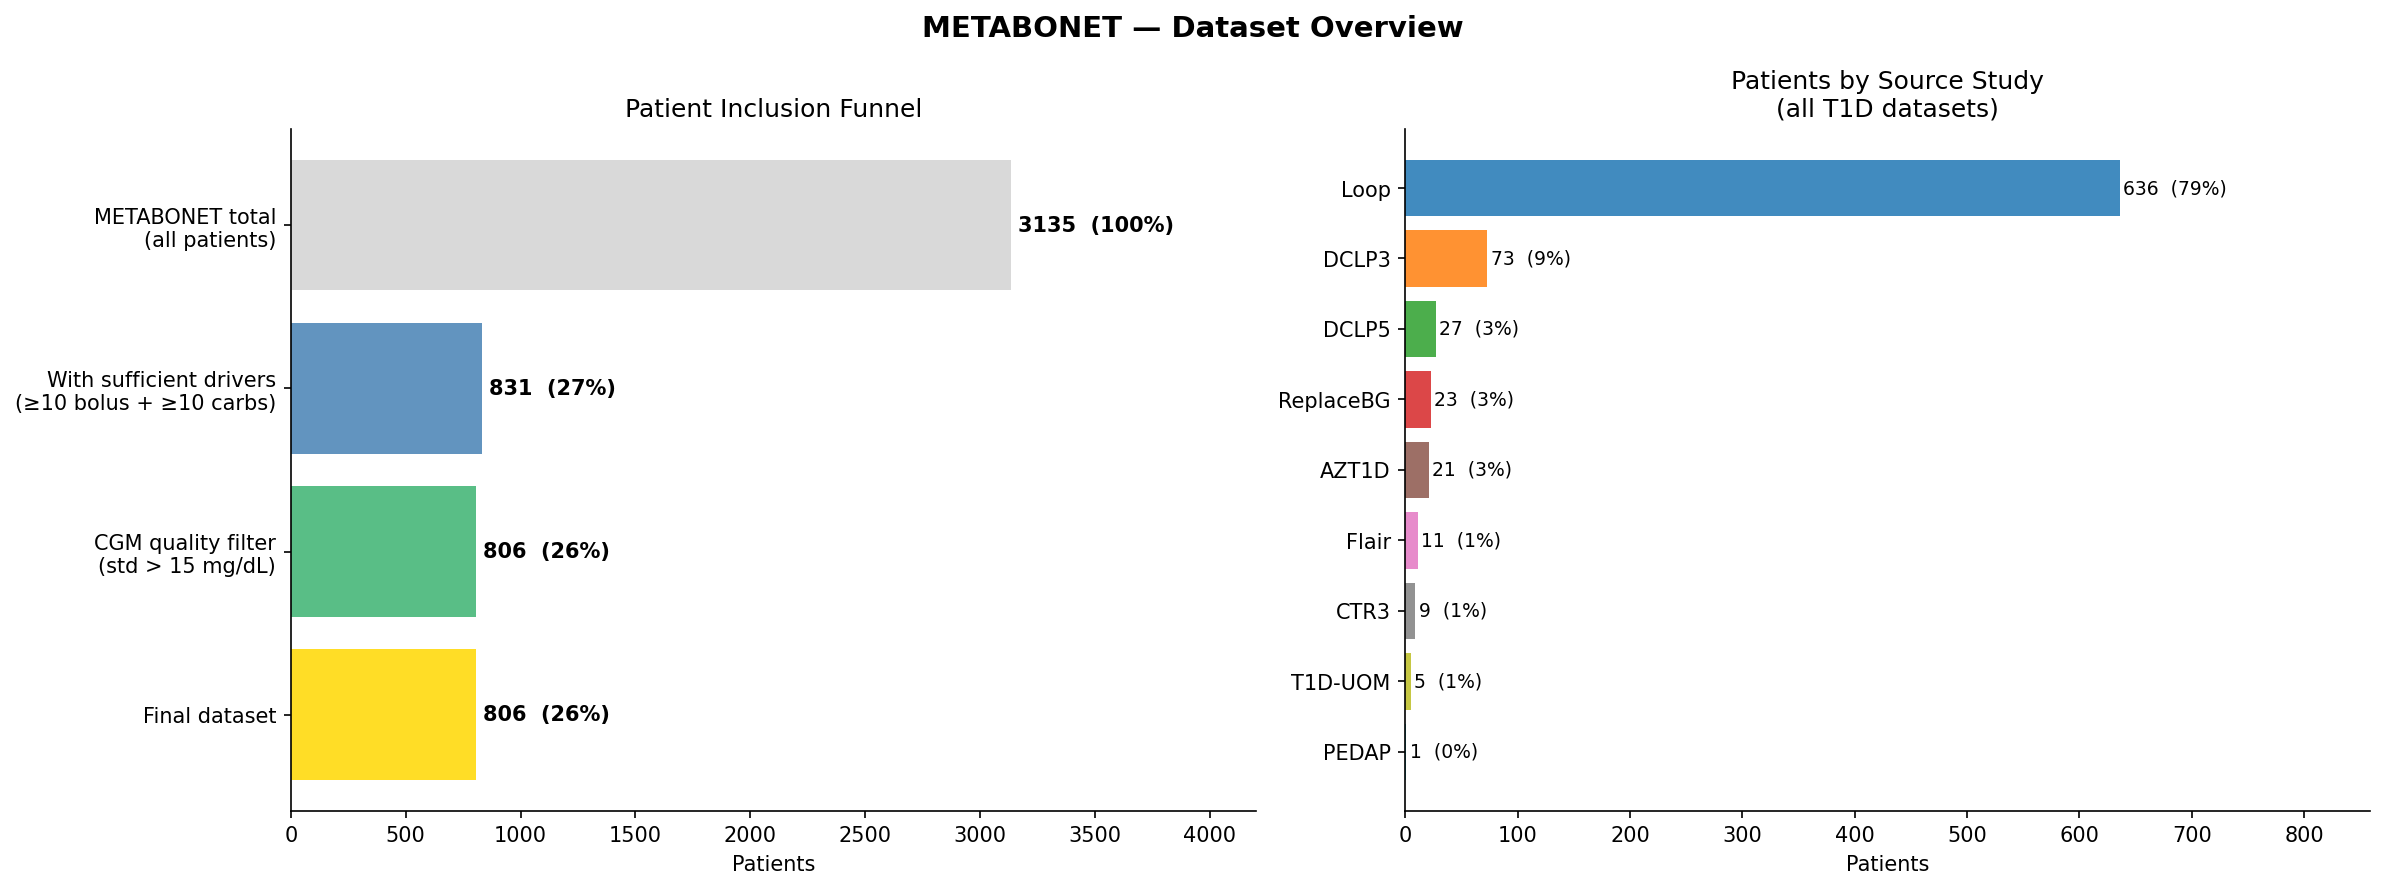

Saved: plots/01_funnel_sources.png


In [7]:
# Cell 6 — Patient inclusion funnel + source datasets
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("METABONET — Dataset Overview", fontsize=14, fontweight='bold')

# 1: Inclusion funnel
ax = axes[0]
stages = ['METABONET total\n(all patients)',
          'With sufficient drivers\n(≥10 bolus + ≥10 carbs)',
          'CGM quality filter\n(std > 15 mg/dL)',
          'Final dataset']
counts = [3135, 831, 806, len(inc)]
colors_f = ['lightgray', 'steelblue', 'mediumseagreen', 'gold']
bars = ax.barh(stages, counts, color=colors_f, alpha=0.85)
for bar, val in zip(bars, counts):
    ax.text(bar.get_width() + 30,
            bar.get_y() + bar.get_height() / 2,
            f'{val}  ({100*val/3135:.0f}%)',
            va='center', fontsize=10, fontweight='bold')
ax.set_xlabel('Patients')
ax.set_title('Patient Inclusion Funnel')
ax.set_xlim(0, 4200)
ax.invert_yaxis()

# 2: Source study distribution
ax = axes[1]
source_counts = df_demo[df_demo['included']]['source_file'].value_counts()
colors_src = plt.cm.tab10(np.linspace(0, 1, len(source_counts)))
bars = ax.barh(source_counts.index, source_counts.values,
               color=colors_src, alpha=0.85)
for bar, val in zip(bars, source_counts.values):
    ax.text(bar.get_width() + 3,
            bar.get_y() + bar.get_height() / 2,
            f'{val}  ({100*val/len(inc):.0f}%)',
            va='center', fontsize=9)
ax.set_xlabel('Patients')
ax.set_title('Patients by Source Study\n(all T1D datasets)')
ax.set_xlim(0, source_counts.max() * 1.35)
ax.invert_yaxis()

plt.tight_layout()
plt.savefig('plots/01_funnel_sources.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: plots/01_funnel_sources.png")

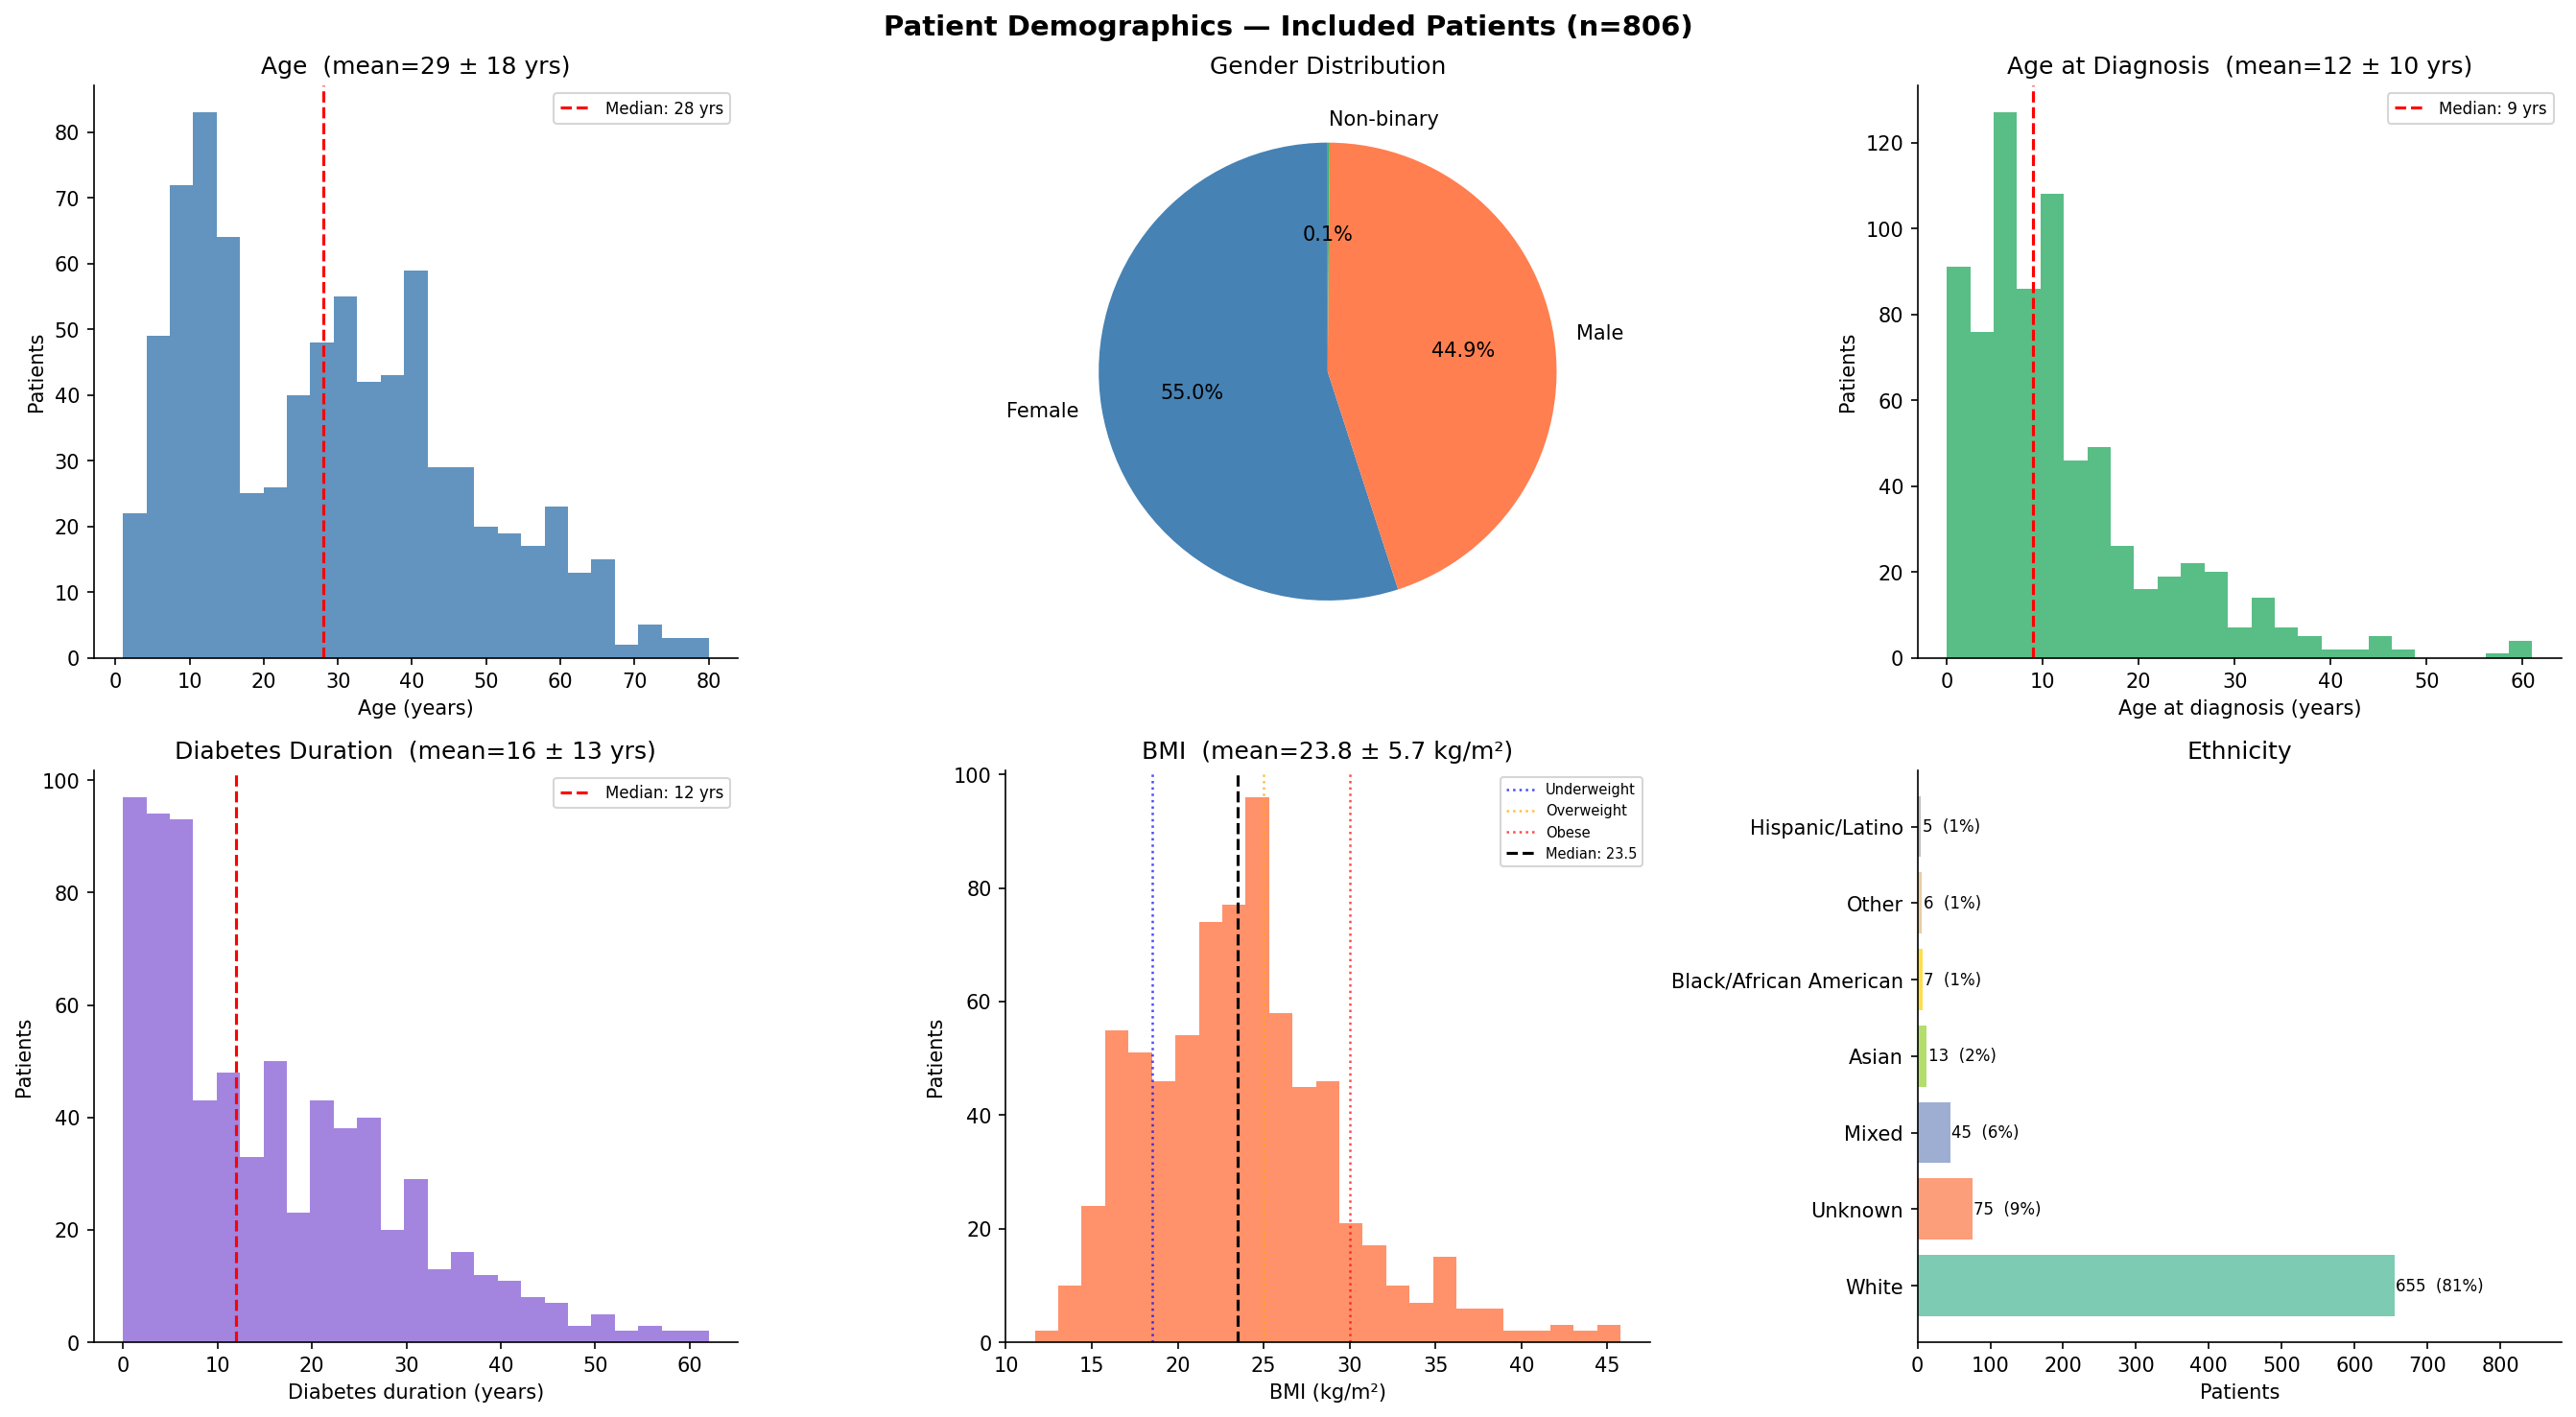

Saved: plots/02_demographics.png


In [8]:
# Cell 7 — Demographics
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle("Patient Demographics — Included Patients (n=806)",
             fontsize=14, fontweight='bold')

# 1: Age
ax = axes[0, 0]
vals = inc['age'].dropna()
ax.hist(vals, bins=25, color='steelblue', alpha=0.85, edgecolor='none')
ax.axvline(vals.median(), color='red', linestyle='--', lw=1.5,
           label=f'Median: {vals.median():.0f} yrs')
ax.set_xlabel('Age (years)')
ax.set_ylabel('Patients')
ax.set_title(f'Age  (mean={vals.mean():.0f} ± {vals.std():.0f} yrs)')
ax.legend(fontsize=8)

# 2: Gender
ax = axes[0, 1]
gender_counts = inc['gender'].value_counts()
colors_g = ['steelblue', 'coral', 'mediumseagreen']
ax.pie(gender_counts.values,
       labels=gender_counts.index,
       colors=colors_g[:len(gender_counts)],
       autopct='%1.1f%%', startangle=90)
ax.set_title('Gender Distribution')

# 3: Age at diagnosis
ax = axes[0, 2]
vals = inc['age_of_diagnosis'].dropna()
ax.hist(vals, bins=25, color='mediumseagreen', alpha=0.85, edgecolor='none')
ax.axvline(vals.median(), color='red', linestyle='--', lw=1.5,
           label=f'Median: {vals.median():.0f} yrs')
ax.set_xlabel('Age at diagnosis (years)')
ax.set_ylabel('Patients')
ax.set_title(f'Age at Diagnosis  (mean={vals.mean():.0f} ± {vals.std():.0f} yrs)')
ax.legend(fontsize=8)

# 4: Diabetes duration
ax = axes[1, 0]
vals = inc['dm_duration'].dropna()
vals = vals[vals >= 0]
ax.hist(vals, bins=25, color='mediumpurple', alpha=0.85, edgecolor='none')
ax.axvline(vals.median(), color='red', linestyle='--', lw=1.5,
           label=f'Median: {vals.median():.0f} yrs')
ax.set_xlabel('Diabetes duration (years)')
ax.set_ylabel('Patients')
ax.set_title(f'Diabetes Duration  (mean={vals.mean():.0f} ± {vals.std():.0f} yrs)')
ax.legend(fontsize=8)

# 5: BMI
ax = axes[1, 1]
vals = inc['bmi'].dropna()
ax.hist(vals, bins=25, color='coral', alpha=0.85, edgecolor='none')
ax.axvline(18.5, color='blue',   linestyle=':', lw=1.2, alpha=0.7, label='Underweight')
ax.axvline(25,   color='orange', linestyle=':', lw=1.2, alpha=0.7, label='Overweight')
ax.axvline(30,   color='red',    linestyle=':', lw=1.2, alpha=0.7, label='Obese')
ax.axvline(vals.median(), color='black', linestyle='--', lw=1.5,
           label=f'Median: {vals.median():.1f}')
ax.set_xlabel('BMI (kg/m²)')
ax.set_ylabel('Patients')
ax.set_title(f'BMI  (mean={vals.mean():.1f} ± {vals.std():.1f} kg/m²)')
ax.legend(fontsize=7)

# 6: Ethnicity (simplified)
ax = axes[1, 2]
eth = inc['ethnicity'].copy()
def simplify_ethnicity(x):
    if not isinstance(x, str):
        return 'Unknown'
    if ',' in x:
        return 'Mixed'
    if 'White' in x:
        return 'White'
    if 'Hispanic' in x:
        return 'Hispanic/Latino'
    if 'Asian' in x:
        return 'Asian'
    if 'Black' in x:
        return 'Black/African American'
    return 'Other'

eth = eth.apply(simplify_ethnicity)
eth_counts = eth.value_counts()
colors_eth = plt.cm.Set2(np.linspace(0, 1, len(eth_counts)))
bars = ax.barh(eth_counts.index, eth_counts.values,
               color=colors_eth, alpha=0.85)
for bar, val in zip(bars, eth_counts.values):
    ax.text(bar.get_width() + 2,
            bar.get_y() + bar.get_height() / 2,
            f'{val}  ({100*val/len(inc):.0f}%)',
            va='center', fontsize=8)
ax.set_xlabel('Patients')
ax.set_title('Ethnicity')
ax.set_xlim(0, eth_counts.max() * 1.35)

plt.tight_layout()
plt.savefig('plots/02_demographics.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: plots/02_demographics.png")

In [9]:
# Cell 8a — Compute TIR per patient per modality (used in Cell 8b)
modality_tir = defaultdict(list)

f = pq.ParquetFile('raw_data/metabonet_train_filtered.parquet')
for batch in f.iter_batches(columns=['id', 'CGM'], batch_size=1_000_000):
    df = batch.to_pandas()
    for pid, grp in df.groupby('id'):
        mod = pid_to_modality.get(pid, 'unknown')
        if mod not in ['AID', 'SAP', 'MDI']:
            continue
        cgm = grp['CGM'].dropna()
        cgm = cgm[cgm.between(CGM_MIN, CGM_MAX)]
        if len(cgm) > 0:
            tir = 100 * cgm.between(TARGET_LOW, TARGET_HIGH).mean()
            modality_tir[mod].append(tir)

for mod in ['AID', 'SAP', 'MDI']:
    vals = modality_tir[mod]
    print(f"{mod}: n={len(vals)} patients, median TIR={np.median(vals):.0f}%")

AID: n=1397 patients, median TIR=48%
SAP: n=55 patients, median TIR=41%
MDI: n=7 patients, median TIR=39%


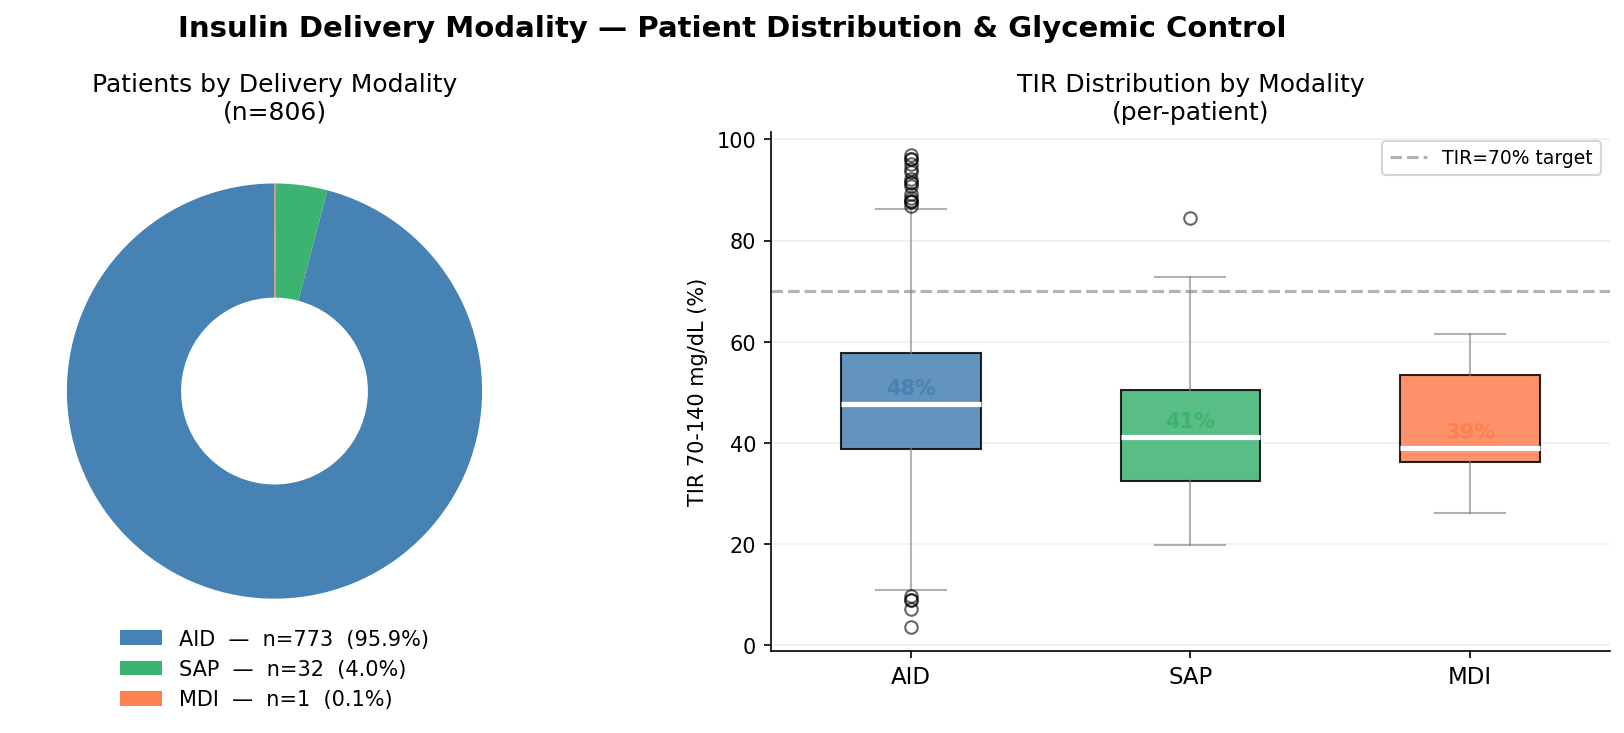

Saved: plots/03_modality_overview.png


In [10]:
# Cell 8b — Modality plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Insulin Delivery Modality — Patient Distribution & Glycemic Control",
             fontsize=14, fontweight='bold')

colors = {'AID': 'steelblue', 'SAP': 'mediumseagreen', 'MDI': 'coral'}

# 1: Donut — sin autopct, solo leyenda
ax = axes[0]
mod_counts = df_valid['modality'].value_counts()
mod_counts = mod_counts[mod_counts.index.isin(['AID', 'SAP', 'MDI'])]
wedge_colors = [colors[m] for m in mod_counts.index]

wedges, _ = ax.pie(
    mod_counts.values,
    colors=wedge_colors,
    startangle=90,
    wedgeprops={'width': 0.55}
)
ax.legend(
    wedges,
    [f'{m}  —  n={v}  ({100*v/mod_counts.sum():.1f}%)' for m, v in mod_counts.items()],
    loc='lower center',
    bbox_to_anchor=(0.5, -0.15),
    fontsize=10,
    frameon=False,
    ncol=1
)
ax.set_title('Patients by Delivery Modality\n(n=806)', fontsize=12)

# 2: TIR boxplot
ax = axes[1]
tir_data = [modality_tir[mod] for mod in ['AID', 'SAP', 'MDI']]
bp = ax.boxplot(tir_data, patch_artist=True, widths=0.5,
                medianprops={'color': 'white', 'linewidth': 2.5})
for patch, mod in zip(bp['boxes'], ['AID', 'SAP', 'MDI']):
    patch.set_facecolor(colors[mod])
    patch.set_alpha(0.85)
for element in ['whiskers', 'caps', 'fliers']:
    for item in bp[element]:
        item.set_color('gray')
        item.set_alpha(0.6)

ax.axhline(70, color='gray', linestyle='--', lw=1.5, alpha=0.6, label='TIR=70% target')
ax.set_xticklabels(['AID', 'SAP', 'MDI'], fontsize=11)
ax.set_ylabel('TIR 70-140 mg/dL (%)')
ax.set_title('TIR Distribution by Modality\n(per-patient)')
ax.legend(fontsize=9)
ax.grid(alpha=0.2, axis='y')

for i, mod in enumerate(['AID', 'SAP', 'MDI']):
    med = np.median(modality_tir[mod])
    ax.text(i + 1, med + 2, f'{med:.0f}%',
            ha='center', fontsize=10, fontweight='bold', color=colors[mod])

plt.tight_layout()
plt.savefig('plots/03_modality_overview.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: plots/03_modality_overview.png")

KeyboardInterrupt: 

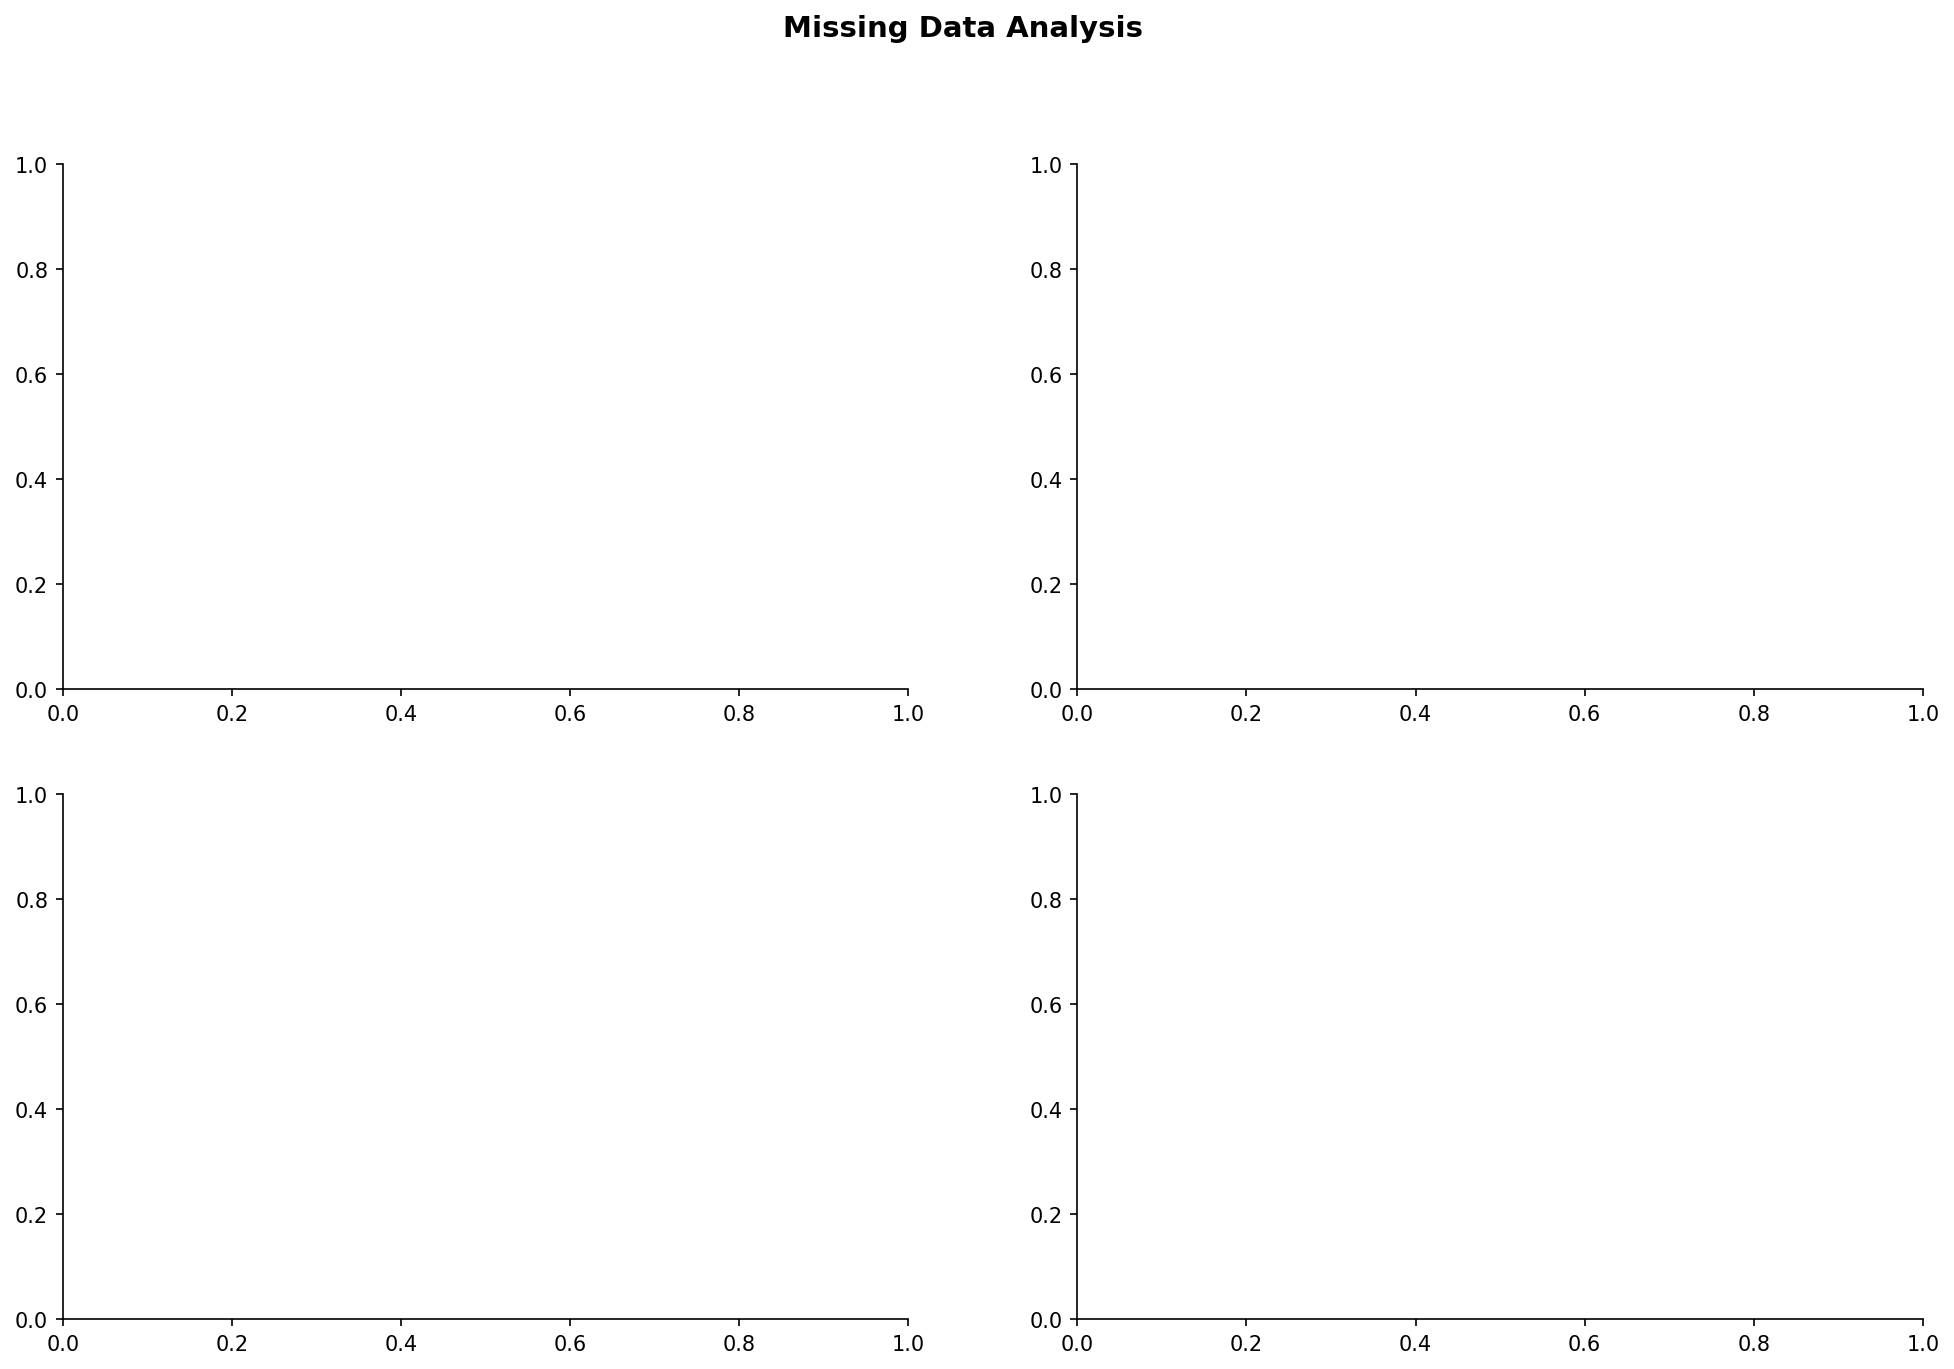

In [11]:
# Cell 9 — Missing data analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle("Missing Data Analysis", fontsize=14, fontweight='bold')

# Accumulate missing by hour + gap lengths (sample 100 patients)
cgm_missing_by_hour  = np.zeros(24)
cgm_count_by_hour    = np.zeros(24)
sample_pids = df_valid.sample(100, random_state=42)['id'].astype(str).tolist()
patient_gaps = defaultdict(list)

f = pq.ParquetFile('raw_data/metabonet_train_filtered.parquet')
for batch in f.iter_batches(columns=['id', 'date', 'CGM'], batch_size=1_000_000):
    df = batch.to_pandas()
    df['date'] = pd.to_datetime(df['date'])
    df['hour'] = df['date'].dt.hour

    for h in range(24):
        hdf = df[df['hour'] == h]
        cgm_missing_by_hour[h] += hdf['CGM'].isna().sum()
        cgm_count_by_hour[h]   += len(hdf)

    for pid in sample_pids:
        chunk = df[df['id'].astype(str) == pid].sort_values('date')
        if len(chunk) == 0:
            continue
        gap_len = 0
        for val in chunk['CGM'].isna().values:
            if val:
                gap_len += 1
            elif gap_len > 0:
                patient_gaps[pid].append(gap_len)
                gap_len = 0

all_gaps = np.array([g for gaps in patient_gaps.values() for g in gaps])

print(f"Gap statistics:")
print(f"  Total gaps    : {len(all_gaps):,}")
print(f"  Median length : {np.median(all_gaps):.0f} steps ({np.median(all_gaps)*5:.0f} min)")
print(f"  Mean length   : {all_gaps.mean():.1f} steps ({all_gaps.mean()*5:.0f} min)")
for steps, label in [(1,'5min'), (6,'30min'), (12,'1h'), (48,'4h'), (288,'24h')]:
    print(f"  <={steps:>3} steps ({label:<5}): {100*(all_gaps<=steps).mean():.1f}%")

# 1: Missing rate by hour
ax = axes[0, 0]
missing_rate = cgm_missing_by_hour / cgm_count_by_hour * 100
ax.bar(range(24), missing_rate, color='steelblue', alpha=0.85)
ax.set_xlabel('Hour of day')
ax.set_ylabel('% Missing CGM')
ax.set_title('Missing CGM Rate by Hour of Day\n(uniform → missing is random, MCAR)')
ax.set_xticks(range(24))
ax.set_xticklabels([f'{h:02d}h' for h in range(24)], rotation=45, fontsize=7)
ax.set_ylim(0, missing_rate.max() * 1.3)
ax.grid(alpha=0.3)

# 2: Gap length distribution
ax = axes[0, 1]
ax.hist(all_gaps[all_gaps <= 288], bins=50,
        color='coral', alpha=0.85, edgecolor='none')
ax.axvline(6,   color='blue',   linestyle='--', lw=1.5, label='30 min')
ax.axvline(12,  color='orange', linestyle='--', lw=1.5, label='1 hour')
ax.axvline(288, color='red',    linestyle='--', lw=1.5, label='24 hours')
ax.set_xlabel('Gap length (5-min steps)')
ax.set_ylabel('Frequency')
ax.set_title('CGM Gap Length Distribution (up to 24h)\n82% of gaps < 1 hour')
ax.legend(fontsize=8)

# 3: Gap length CDF
ax = axes[1, 0]
sorted_gaps = np.sort(all_gaps)
cdf = np.arange(1, len(sorted_gaps) + 1) / len(sorted_gaps)
ax.plot(sorted_gaps[sorted_gaps <= 576],
        cdf[sorted_gaps <= 576],
        color='steelblue', lw=2)
ax.axvline(12,  color='orange', linestyle='--', lw=1.5, label='1 hour (82%)')
ax.axvline(288, color='red',    linestyle='--', lw=1.5, label='24 hours (99%)')
ax.set_xlabel('Gap length (5-min steps)')
ax.set_ylabel('Cumulative probability')
ax.set_title('CDF of Gap Lengths')
ax.legend(fontsize=8)
ax.grid(alpha=0.3)

# 4: Missing % per patient
ax = axes[1, 1]
ax.hist(df_valid['cgm_missing_pct'], bins=40,
        color='mediumseagreen', alpha=0.85, edgecolor='none')
ax.axvline(df_valid['cgm_missing_pct'].median(),
           color='red', linestyle='--', lw=1.5,
           label=f"Median: {df_valid['cgm_missing_pct'].median():.1f}%")
ax.axvline(50, color='orange', linestyle='--', lw=1.5, label='Exclusion threshold (50%)')
ax.set_xlabel('% Missing CGM per patient')
ax.set_ylabel('Patients')
ax.set_title('Missing CGM Distribution across Patients')
ax.legend(fontsize=8)

plt.tight_layout()
plt.savefig('plots/04_missing_data.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: plots/04_missing_data.png")

KeyboardInterrupt: 

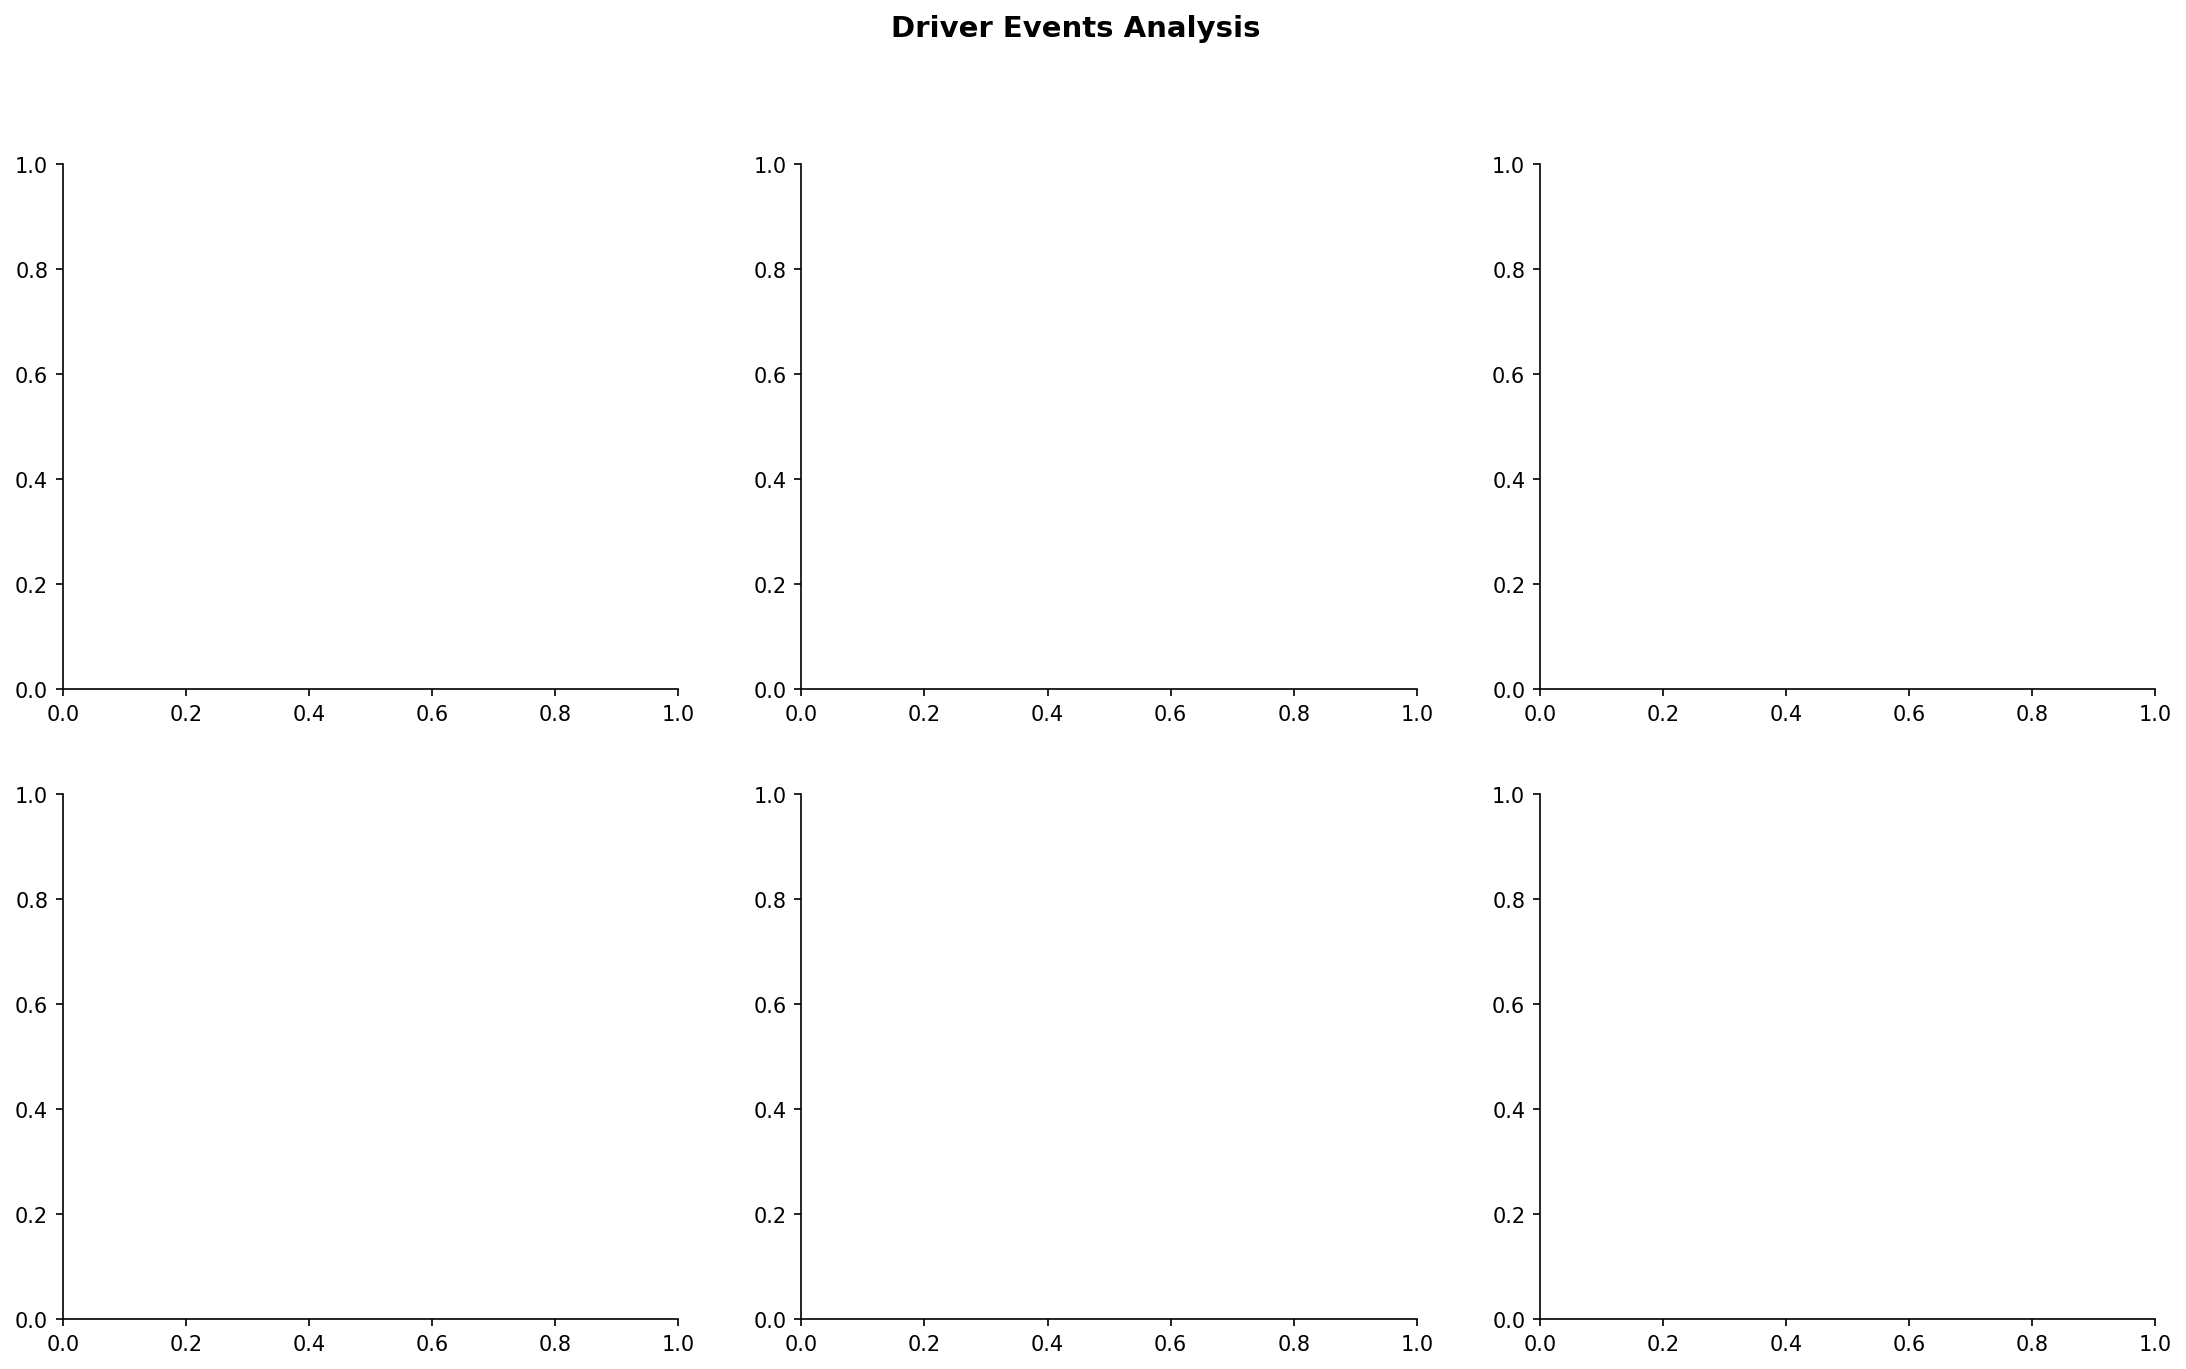

In [12]:
# Cell 10 — Driver events analysis + co-occurrence
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle("Driver Events Analysis", fontsize=14, fontweight='bold')

# Accumulate driver stats in streaming
driver_stats = {
    'bolus': np.zeros(24), 'carbs': np.zeros(24), 'basal': np.zeros(24),
}
driver_count_by_hour = np.zeros(24)
cooccurrence = {'bolus_and_carbs': 0, 'bolus_only': 0,
                'carbs_only': 0, 'neither': 0}

f = pq.ParquetFile('raw_data/metabonet_train_filtered.parquet')
for batch in f.iter_batches(
        columns=['id', 'date', 'CGM', 'bolus', 'basal', 'carbs'],
        batch_size=1_000_000):
    df = batch.to_pandas()
    df['date'] = pd.to_datetime(df['date'])
    df['hour'] = df['date'].dt.hour

    for h in range(24):
        hdf = df[df['hour'] == h]
        driver_stats['bolus'][h] += (hdf['bolus'] > 0).sum()
        driver_stats['carbs'][h] += (hdf['carbs'] > 0).sum()
        driver_stats['basal'][h] += (hdf['basal'] > 0).sum()
        driver_count_by_hour[h]  += len(hdf)

    # Co-occurrence on rows with valid CGM
    valid = df.dropna(subset=['CGM'])
    has_bolus = valid['bolus'] > 0
    has_carbs = valid['carbs'] > 0
    cooccurrence['bolus_and_carbs'] += (has_bolus & has_carbs).sum()
    cooccurrence['bolus_only']      += (has_bolus & ~has_carbs).sum()
    cooccurrence['carbs_only']      += (~has_bolus & has_carbs).sum()
    cooccurrence['neither']         += (~has_bolus & ~has_carbs).sum()

total_events = cooccurrence['bolus_and_carbs'] + \
               cooccurrence['bolus_only'] + \
               cooccurrence['carbs_only']

print("Driver co-occurrence (rows with at least one event):")
print(f"  Bolus AND Carbs : {cooccurrence['bolus_and_carbs']:,} ({100*cooccurrence['bolus_and_carbs']/total_events:.1f}%)")
print(f"  Bolus only      : {cooccurrence['bolus_only']:,} ({100*cooccurrence['bolus_only']/total_events:.1f}%)")
print(f"  Carbs only      : {cooccurrence['carbs_only']:,} ({100*cooccurrence['carbs_only']/total_events:.1f}%)")
print(f"\n  → Driver-Blindness: {100*cooccurrence['bolus_only']/total_events:.1f}% of bolus events have no carb record")

# 1: Event rate by hour — bolus
ax = axes[0, 0]
ax.bar(range(24), 100 * driver_stats['bolus'] / driver_count_by_hour,
       color='coral', alpha=0.85)
ax.set_xlabel('Hour of day')
ax.set_ylabel('% rows with event > 0')
ax.set_title('Bolus Events by Hour of Day')
ax.set_xticks(range(24))
ax.set_xticklabels([f'{h:02d}h' for h in range(24)], rotation=45, fontsize=7)
ax.grid(alpha=0.3)

# 2: Event rate by hour — carbs
ax = axes[0, 1]
ax.bar(range(24), 100 * driver_stats['carbs'] / driver_count_by_hour,
       color='gold', alpha=0.85)
ax.set_xlabel('Hour of day')
ax.set_ylabel('% rows with event > 0')
ax.set_title('Carbs Events by Hour of Day')
ax.set_xticks(range(24))
ax.set_xticklabels([f'{h:02d}h' for h in range(24)], rotation=45, fontsize=7)
ax.grid(alpha=0.3)

# 3: Event rate by hour — basal
ax = axes[0, 2]
ax.bar(range(24), 100 * driver_stats['basal'] / driver_count_by_hour,
       color='steelblue', alpha=0.85)
ax.set_xlabel('Hour of day')
ax.set_ylabel('% rows with event > 0')
ax.set_title('Basal Events by Hour of Day')
ax.set_xticks(range(24))
ax.set_xticklabels([f'{h:02d}h' for h in range(24)], rotation=45, fontsize=7)
ax.grid(alpha=0.3)

# 4: Co-occurrence pie (event rows only)
ax = axes[1, 0]
labels = ['Bolus + Carbs', 'Bolus only', 'Carbs only']
sizes  = [cooccurrence['bolus_and_carbs'],
          cooccurrence['bolus_only'],
          cooccurrence['carbs_only']]
colors_pie = ['mediumseagreen', 'coral', 'gold']
ax.pie(sizes, labels=labels, colors=colors_pie,
       autopct='%1.1f%%', startangle=90)
ax.set_title('Driver Co-occurrence\n(rows with ≥1 event)\nDriver-Blindness confirmed')

# 5: Bolus events per patient distribution
ax = axes[1, 1]
ax.hist(df_valid['bolus_per_day'], bins=40,
        color='coral', alpha=0.85, edgecolor='none')
ax.axvline(df_valid['bolus_per_day'].median(), color='red',
           linestyle='--', lw=1.5,
           label=f"Median: {df_valid['bolus_per_day'].median():.1f}/day")
ax.set_xlabel('Bolus events per day')
ax.set_ylabel('Patients')
ax.set_title('Bolus Event Rate per Patient')
ax.legend(fontsize=8)

# 6: Carbs events per patient distribution
ax = axes[1, 2]
ax.hist(df_valid['carbs_per_day'], bins=40,
        color='gold', alpha=0.85, edgecolor='none')
ax.axvline(df_valid['carbs_per_day'].median(), color='red',
           linestyle='--', lw=1.5,
           label=f"Median: {df_valid['carbs_per_day'].median():.1f}/day")
ax.set_xlabel('Carbs events per day')
ax.set_ylabel('Patients')
ax.set_title('Carbs Event Rate per Patient')
ax.legend(fontsize=8)

plt.tight_layout()
plt.savefig('plots/05_driver_events.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: plots/05_driver_events.png")

## Driver Co-occurrence — Key Finding: Driver-Blindness

### What we observe
- **78.2% of bolus events have no carb record** at the same timestamp
- Only **15.4% of events** have both bolus AND carbs logged simultaneously
- **6.4% carbs only** — meal logged without corresponding bolus

### Why this happens

**1. Insulin delivery modality (75% AID)**
In closed-loop systems the pump delivers micro-boluses automatically every 
few minutes based on the CGM signal. These are recorded as bolus events but 
have no associated meal — the algorithm is just doing its job autonomously.
This alone explains a large fraction of the 78.2%.

**2. Annotation decay**
Patients are supposed to log meals manually. In practice, compliance drops 
over time — especially in long studies (median 423 days). A patient may log 
carbs consistently in week 1 but stop by month 6.

**3. Dataset heterogeneity**
Some source studies (e.g. IOBP2) record all insulin as bolus regardless of 
type. Others have different carb logging protocols. This creates structural 
missingness that varies by source.

**4. Correction boluses**
A significant fraction of bolus events are correction boluses — the patient 
is high and injects insulin without eating. These are legitimate bolus events 
with no associated carbs.

### Why this matters for the model
The model cannot distinguish:
- "Patient did not eat" (true zero carbs)
- "Patient ate but did not log it" (missing annotation)

A binary feature `carbs_logged` (1 if carbs > 0, 0 otherwise) helps the 
model learn **when to trust the carbs signal** — not when it is zero vs 
non-zero, but whether the signal is reliable at all. It does not solve 
Driver-Blindness, it mitigates the noise it introduces.

**The real solution is the model itself**: the VAE latent space should learn 
to infer missing drivers from the CGM signal. A characteristic postprandial 
glucose rise without any carb annotation should activate a latent dimension 
corresponding to an unlogged meal. This is the core hypothesis of the project.

### Note on IOBP2
In the IOBP2 dataset all insulin is recorded as bolus (no basal column).
This inflates bolus event counts for those patients and must be handled
in preprocessing by using the `insulin` column as primary signal for 
total insulin exposure.

Valid postprandial windows:
  AID: 793,725
  SAP: 20,492
  MDI: 66


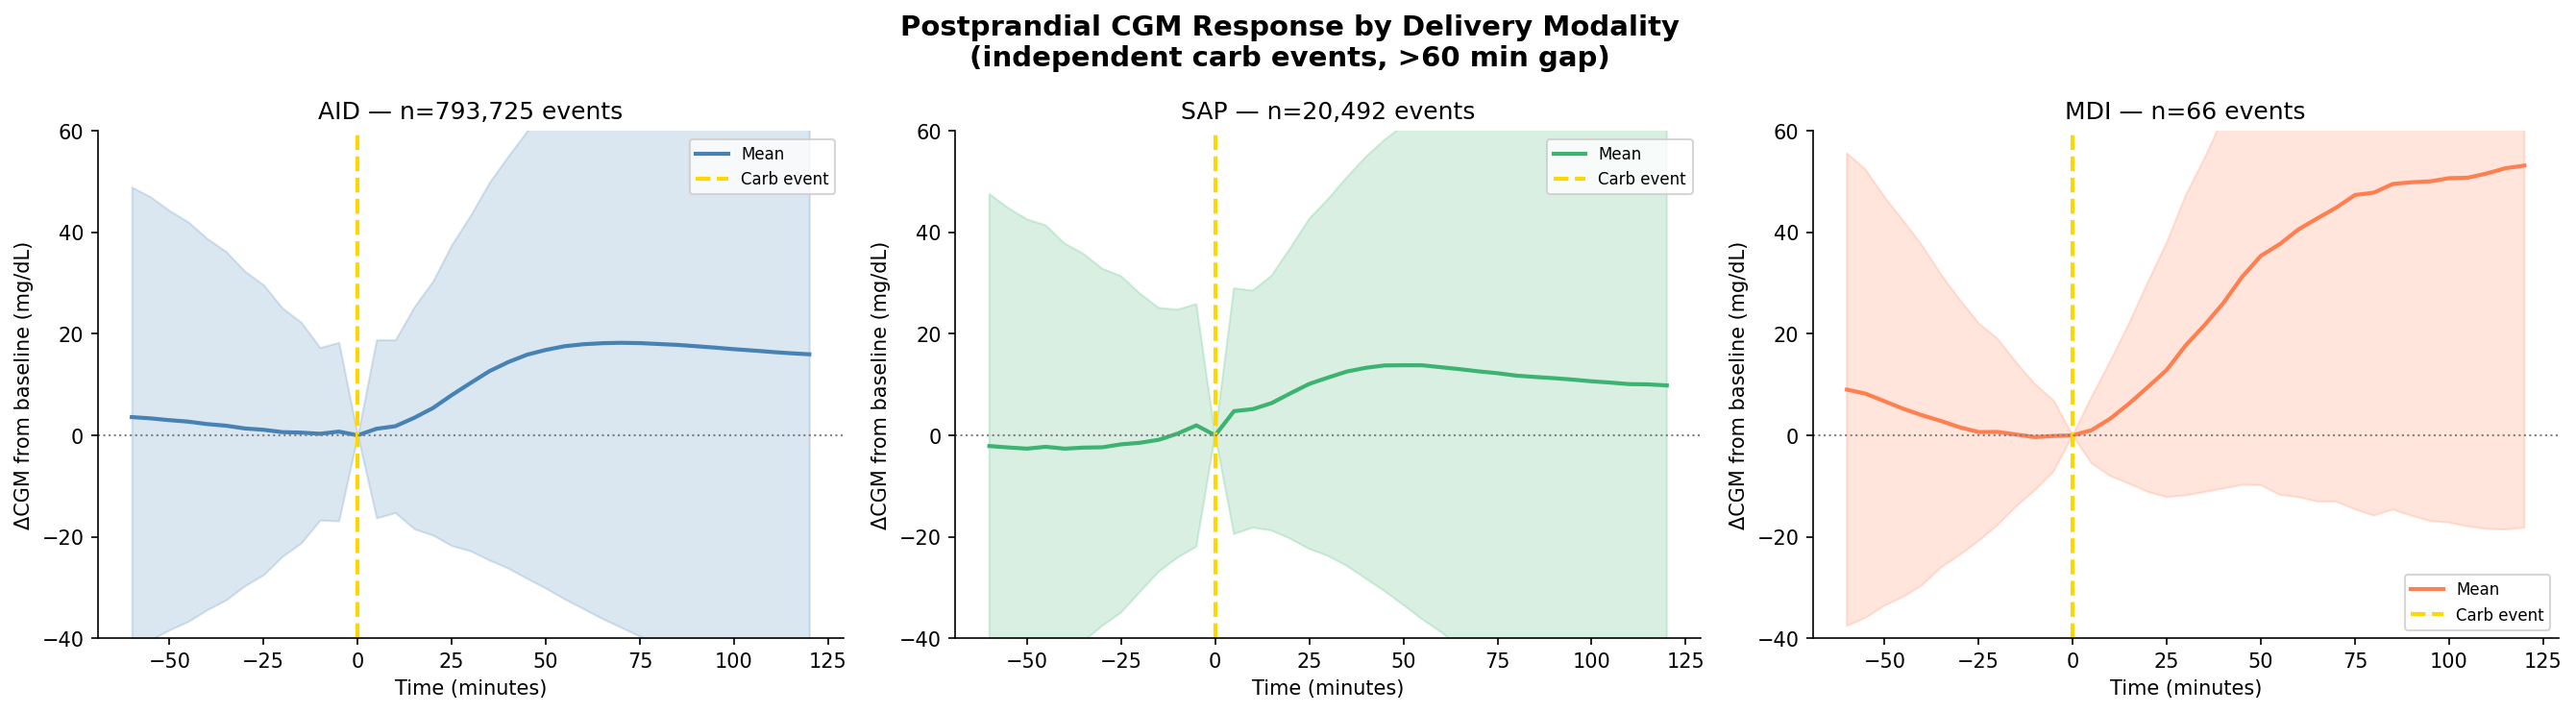

Saved: plots/06_postprandial_response.png


In [ ]:
# Cell 11 — Postprandial response by delivery modality
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Postprandial CGM Response by Delivery Modality\n"
             "(independent carb events, >60 min gap)",
             fontsize=14, fontweight='bold')

pre_steps  = 12  # 1h before
post_steps = 24  # 2h after
all_windows = {'AID': [], 'SAP': [], 'MDI': []}

# Load data per modality in streaming
f = pq.ParquetFile('raw_data/metabonet_train_filtered.parquet')
patient_buffers = defaultdict(list)

for batch in f.iter_batches(
        columns=['id', 'date', 'CGM', 'carbs'],
        batch_size=1_000_000):
    df = batch.to_pandas()
    df['date'] = pd.to_datetime(df['date'])
    for pid, grp in df.groupby('id'):
        patient_buffers[pid].append(grp)

for pid, chunks in patient_buffers.items():
    mod = pid_to_modality.get(pid, 'unknown')
    if mod not in ['AID', 'SAP', 'MDI']:
        continue

    df_p = pd.concat(chunks).sort_values('date').reset_index(drop=True)

    # Independent carb events only (>60 min gap)
    carb_events = df_p[df_p['carbs'] > 0].copy()
    carb_events['time_diff'] = carb_events['date'].diff().dt.total_seconds() / 60
    independent_idx = carb_events[
        (carb_events['time_diff'].isna()) |
        (carb_events['time_diff'] > 60)
    ].index.tolist()

    for idx in independent_idx:
        if idx < pre_steps or idx + post_steps >= len(df_p):
            continue
        window = df_p.loc[idx - pre_steps:idx + post_steps, 'CGM'].values
        if len(window) == post_steps + pre_steps + 1 and not np.isnan(window).any():
            baseline = window[pre_steps]
            if baseline > 0:
                all_windows[mod].append(window - baseline)

print("Valid postprandial windows:")
for mod in ['AID', 'SAP', 'MDI']:
    print(f"  {mod}: {len(all_windows[mod]):,}")

colors    = {'AID': 'steelblue', 'SAP': 'mediumseagreen', 'MDI': 'coral'}
time_axis = np.arange(-pre_steps, post_steps + 1) * 5

for ax, mod in zip(axes, ['AID', 'SAP', 'MDI']):
    windows = np.array(all_windows[mod])
    mean_r  = windows.mean(axis=0)
    std_r   = windows.std(axis=0)
    ax.fill_between(time_axis, mean_r - std_r, mean_r + std_r,
                    alpha=0.2, color=colors[mod])
    ax.plot(time_axis, mean_r, color=colors[mod], lw=2, label='Mean')
    ax.axvline(0, color='gold', linestyle='--', lw=2, label='Carb event')
    ax.axhline(0, color='gray', linestyle=':', lw=1)
    ax.set_xlabel('Time (minutes)')
    ax.set_ylabel('ΔCGM from baseline (mg/dL)')
    ax.set_title(f'{mod} — n={len(windows):,} events')
    ax.legend(fontsize=8)
    ax.set_ylim(-40, 60)

plt.tight_layout()
plt.savefig('plots/06_postprandial_response.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: plots/06_postprandial_response.png")

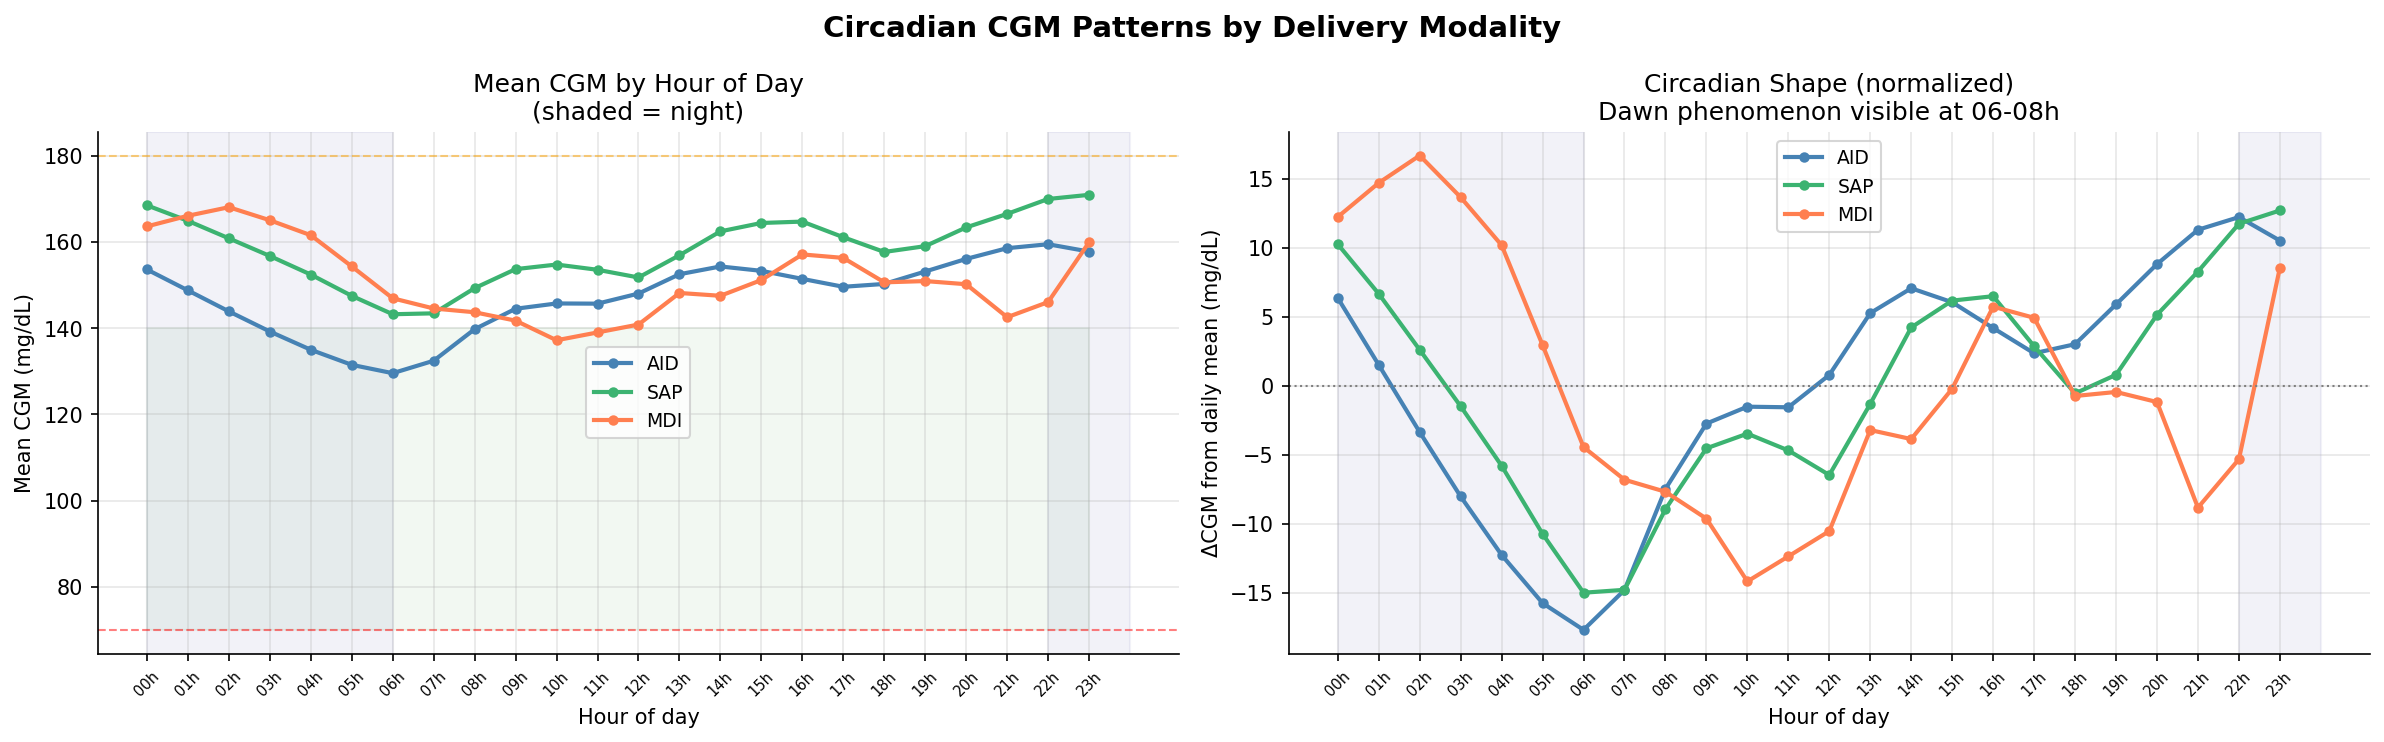

Saved: plots/07_circadian_patterns.png


In [ ]:
# Cell 12 — Circadian patterns by delivery modality
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle("Circadian CGM Patterns by Delivery Modality",
             fontsize=14, fontweight='bold')

# Accumulate CGM by hour per modality in streaming
hour_stats = {
    mod: {'sum': np.zeros(24), 'count': np.zeros(24)}
    for mod in ['AID', 'SAP', 'MDI']
}

f = pq.ParquetFile('raw_data/metabonet_train_filtered.parquet')
for batch in f.iter_batches(columns=['id', 'date', 'CGM'], batch_size=1_000_000):
    df = batch.to_pandas()
    df['date']     = pd.to_datetime(df['date'])
    df['hour']     = df['date'].dt.hour
    df['modality'] = df['id'].map(pid_to_modality)
    df = df.dropna(subset=['CGM'])
    df = df[df['CGM'].between(CGM_MIN, CGM_MAX)]

    for mod in ['AID', 'SAP', 'MDI']:
        grp = df[df['modality'] == mod]
        for h in range(24):
            vals = grp[grp['hour'] == h]['CGM']
            hour_stats[mod]['sum'][h]   += vals.sum()
            hour_stats[mod]['count'][h] += len(vals)

hours  = np.arange(24)
colors = {'AID': 'steelblue', 'SAP': 'mediumseagreen', 'MDI': 'coral'}

# 1: Absolute mean CGM by hour
ax = axes[0]
for mod in ['AID', 'SAP', 'MDI']:
    mean_by_hour = np.where(
        hour_stats[mod]['count'] > 0,
        hour_stats[mod]['sum'] / hour_stats[mod]['count'],
        np.nan
    )
    ax.plot(hours, mean_by_hour, color=colors[mod],
            lw=2, marker='o', markersize=4, label=mod)

ax.axhline(HYPO_THRESHOLD,  color='red',    linestyle='--', lw=1, alpha=0.5)
ax.axhline(HYPER_THRESHOLD, color='orange', linestyle='--', lw=1, alpha=0.5)
ax.fill_between(hours, TARGET_LOW, TARGET_HIGH, alpha=0.05, color='green')
ax.axvspan(0,  6,  alpha=0.05, color='navy')
ax.axvspan(22, 24, alpha=0.05, color='navy')
ax.set_xlabel('Hour of day')
ax.set_ylabel('Mean CGM (mg/dL)')
ax.set_title('Mean CGM by Hour of Day\n(shaded = night)')
ax.set_xticks(hours)
ax.set_xticklabels([f'{h:02d}h' for h in hours], rotation=45, fontsize=7)
ax.legend(fontsize=9)
ax.grid(alpha=0.3)

# 2: Normalized — circadian shape
ax = axes[1]
for mod in ['AID', 'SAP', 'MDI']:
    mean_by_hour = np.where(
        hour_stats[mod]['count'] > 0,
        hour_stats[mod]['sum'] / hour_stats[mod]['count'],
        np.nan
    )
    daily_mean = np.nanmean(mean_by_hour)
    normalized = mean_by_hour - daily_mean
    ax.plot(hours, normalized, color=colors[mod],
            lw=2, marker='o', markersize=4, label=mod)

ax.axhline(0, color='gray', linestyle=':', lw=1)
ax.axvspan(0,  6,  alpha=0.05, color='navy')
ax.axvspan(22, 24, alpha=0.05, color='navy')
ax.set_xlabel('Hour of day')
ax.set_ylabel('ΔCGM from daily mean (mg/dL)')
ax.set_title('Circadian Shape (normalized)\nDawn phenomenon visible at 06-08h')
ax.set_xticks(hours)
ax.set_xticklabels([f'{h:02d}h' for h in hours], rotation=45, fontsize=7)
ax.legend(fontsize=9)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('plots/07_circadian_patterns.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: plots/07_circadian_patterns.png")

PCA explained variance: PC1=53.2%  PC2=25.2%  Total=78.4%

Cluster summary (k=3):
         cgm_mean  cgm_std  bolus_per_day  carbs_per_day
cluster                                                 
0          151.37    58.14          80.65           3.18
1          130.32    43.80           8.99           4.72
2          160.73    61.95           7.28           2.24

Modality distribution per cluster:
modality  AID  MDI  SAP
cluster                
0           7    0    1
1         354    0    7
2         412    1   24


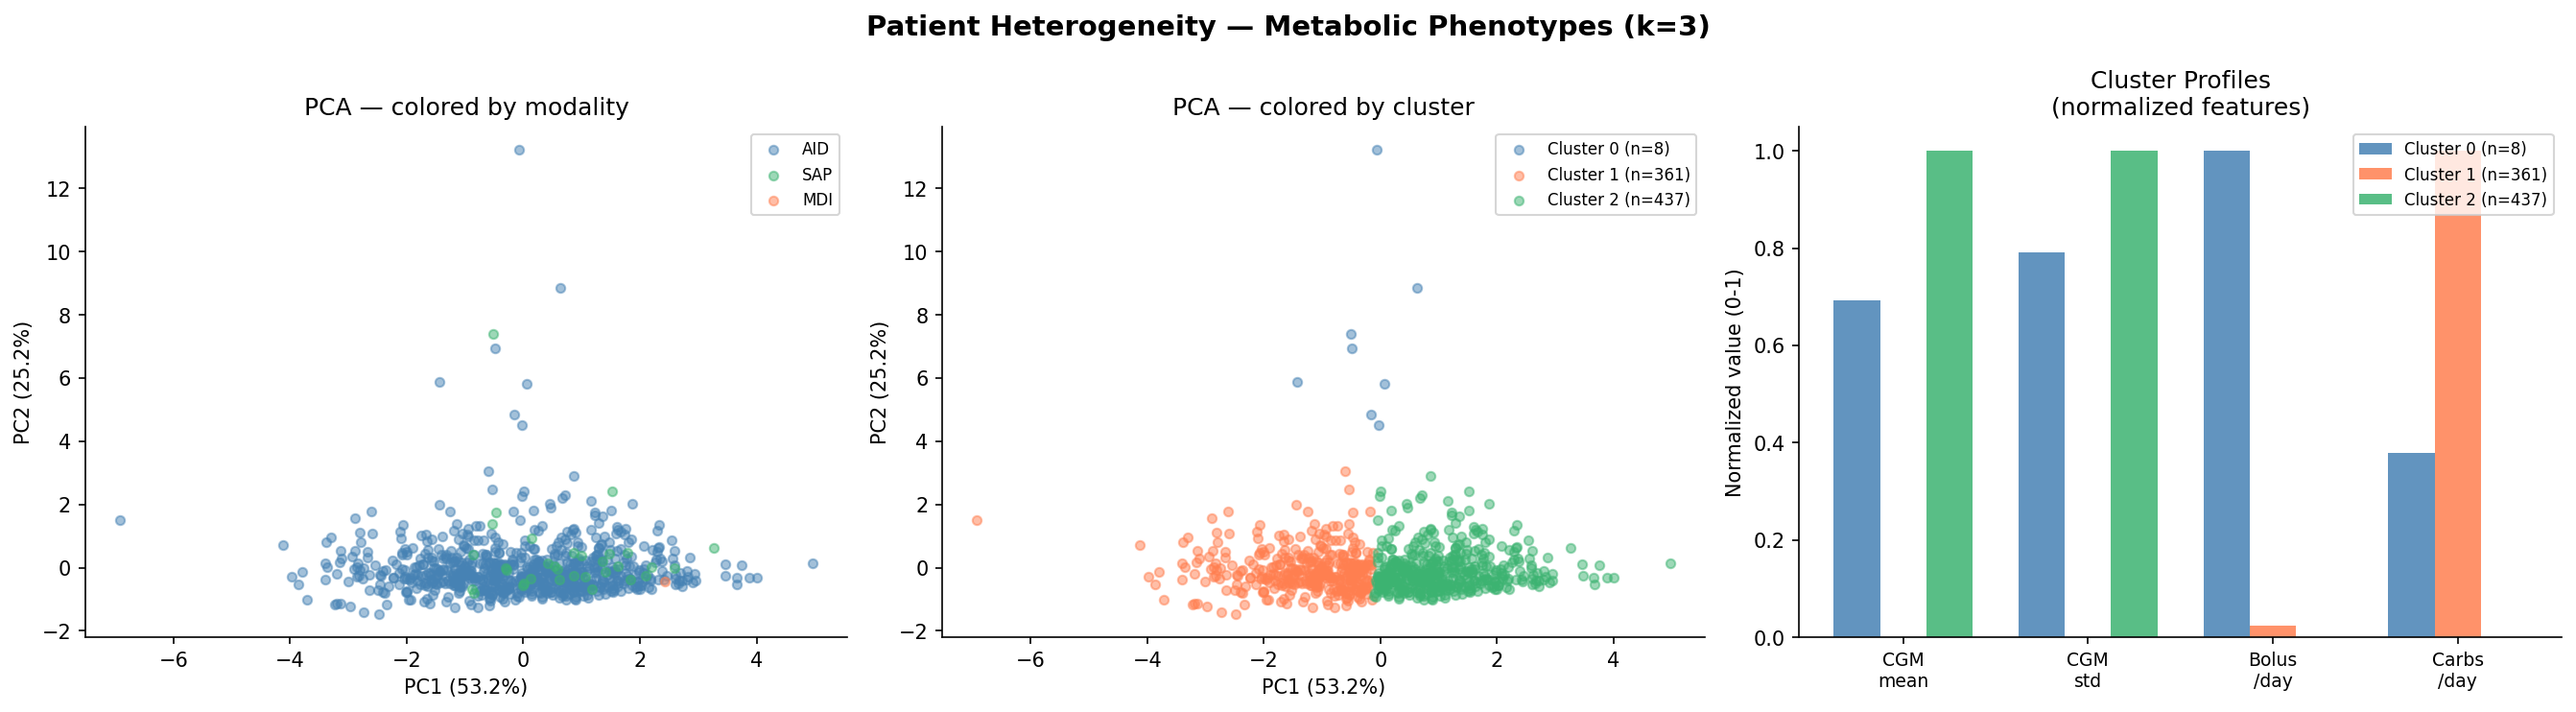

Saved: plots/08_heterogeneity.png


In [ ]:
# Cell 13 — Patient heterogeneity / metabolic phenotypes
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Prepare clustering features
cluster_features = ['cgm_mean', 'cgm_std', 'bolus_per_day', 'carbs_per_day']

df_cluster = df_valid[cluster_features + ['id', 'modality']].dropna().copy()
X          = df_cluster[cluster_features].values
X_scaled   = StandardScaler().fit_transform(X)

# PCA
pca   = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print(f"PCA explained variance: PC1={pca.explained_variance_ratio_[0]:.1%}  "
      f"PC2={pca.explained_variance_ratio_[1]:.1%}  "
      f"Total={pca.explained_variance_ratio_.sum():.1%}")

# KMeans k=3
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_cluster['cluster'] = kmeans.fit_predict(X_scaled)

print("\nCluster summary (k=3):")
print(df_cluster.groupby('cluster')[cluster_features].mean().round(2))
print("\nModality distribution per cluster:")
print(pd.crosstab(df_cluster['cluster'], df_cluster['modality']))

# Plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Patient Heterogeneity — Metabolic Phenotypes (k=3)",
             fontsize=14, fontweight='bold')

mod_colors     = {'AID': 'steelblue', 'SAP': 'mediumseagreen',
                  'MDI': 'coral', 'unknown': 'gray'}
cluster_colors = ['steelblue', 'coral', 'mediumseagreen']

# 1: PCA colored by modality
ax = axes[0]
for mod in ['AID', 'SAP', 'MDI']:
    mask = df_cluster['modality'] == mod
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1],
               c=mod_colors[mod], alpha=0.5, s=20, label=mod)
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
ax.set_title('PCA — colored by modality')
ax.legend(fontsize=8)

# 2: PCA colored by cluster
ax = axes[1]
for c in range(3):
    mask = df_cluster['cluster'] == c
    n    = mask.sum()
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1],
               c=cluster_colors[c], alpha=0.5, s=20,
               label=f'Cluster {c} (n={n})')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
ax.set_title('PCA — colored by cluster')
ax.legend(fontsize=8)

# 3: Cluster profiles — radar-style bar chart
ax = axes[2]
x      = np.arange(len(cluster_features))
width  = 0.25
means  = df_cluster.groupby('cluster')[cluster_features].mean()
# Normalize each feature to 0-1 for comparison
means_norm = (means - means.min()) / (means.max() - means.min())

for c in range(3):
    n = (df_cluster['cluster'] == c).sum()
    ax.bar(x + c * width, means_norm.iloc[c],
           width, color=cluster_colors[c],
           alpha=0.85, label=f'Cluster {c} (n={n})')

ax.set_xticks(x + width)
ax.set_xticklabels(['CGM\nmean', 'CGM\nstd', 'Bolus\n/day', 'Carbs\n/day'],
                   fontsize=9)
ax.set_ylabel('Normalized value (0-1)')
ax.set_title('Cluster Profiles\n(normalized features)')
ax.legend(fontsize=8)

plt.tight_layout()
plt.savefig('plots/08_heterogeneity.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: plots/08_heterogeneity.png")

In [ ]:
# Cell 13b — PCA component interpretation
feature_names = cluster_features
components = pd.DataFrame(
    pca.components_,
    columns=feature_names,
    index=['PC1', 'PC2']
)

print("PCA component loadings:")
print(components.round(3))
print("\nInterpretation:")
for pc in ['PC1', 'PC2']:
    dominant = components.loc[pc].abs().idxmax()
    direction = "↑" if components.loc[pc][dominant] > 0 else "↓"
    print(f"  {pc}: dominated by {dominant} {direction}")

PCA component loadings:
     cgm_mean  cgm_std  bolus_per_day  carbs_per_day
PC1     0.633    0.631         -0.088         -0.441
PC2     0.115    0.143          0.967          0.178

Interpretation:
  PC1: dominated by cgm_mean ↑
  PC2: dominated by bolus_per_day ↑


## Patient Heterogeneity — Key Findings

### PCA structure
PC1 (53.2%) + PC2 (25.2%) = **78.4% of variance explained** with just 2 components.
This confirms strong structure in the patient space — patients are not randomly 
distributed, there are real metabolic differences that the model should capture.

### What PC1 and PC2 represent

**PC1 (53.2%) — Glycemic control axis**
Loadings: cgm_mean=0.633, cgm_std=0.631, carbs_per_day=-0.441

Patients to the **right** of PC1 have higher CGM mean and std (worse control)
and fewer carbs logged. Patients to the **left** have better glycemic control
and more carb annotations. PC1 essentially separates well-controlled from 
poorly-controlled patients.

**PC2 (25.2%) — Treatment intensity axis**
Loadings: bolus_per_day=0.967 (dominant)

PC2 is almost entirely explained by bolus frequency. Patients **high** on PC2 
receive many bolus events per day — these are the Cluster 0 outliers with 
automated micro-bolusing. Patients **low** on PC2 have fewer bolus events.

### Three metabolic phenotypes (k=3)

**Cluster 0 (n=8) — High-frequency bolus users**
- 80 bolus/day → AID algorithm delivering micro-boluses very frequently
- Outliers on PC2 — high treatment intensity, distinct from the rest

**Cluster 1 (n=361) — Well-controlled patients**
- Lowest CGM mean (130 mg/dL) and std (43 mg/dL)
- Most carbs/day (4.72) → better annotation compliance
- Left side of PC1 — best glycemic control

**Cluster 2 (n=437) — Poorly-controlled patients**
- Highest CGM mean (161 mg/dL) and std (62 mg/dL)
- Fewest driver events → less active management or worse compliance
- Right side of PC1 — worst glycemic control

### Key observation
Clusters do **not** align perfectly with delivery modality — both Cluster 1 
and Cluster 2 are predominantly AID. Glycemic control is not fully explained 
by device type alone. Patient behavior and compliance play a major role.

### Implication for the model
The latent space of the VAE should naturally recover these phenotypes.
Cluster labels can be used as a post-hoc evaluation metric — if the latent 
space is meaningful, patients from the same cluster should be close together 
in latent space without ever being told the cluster labels during training.

Selected patient: 172 (SAP, 6.9 carbs/day)


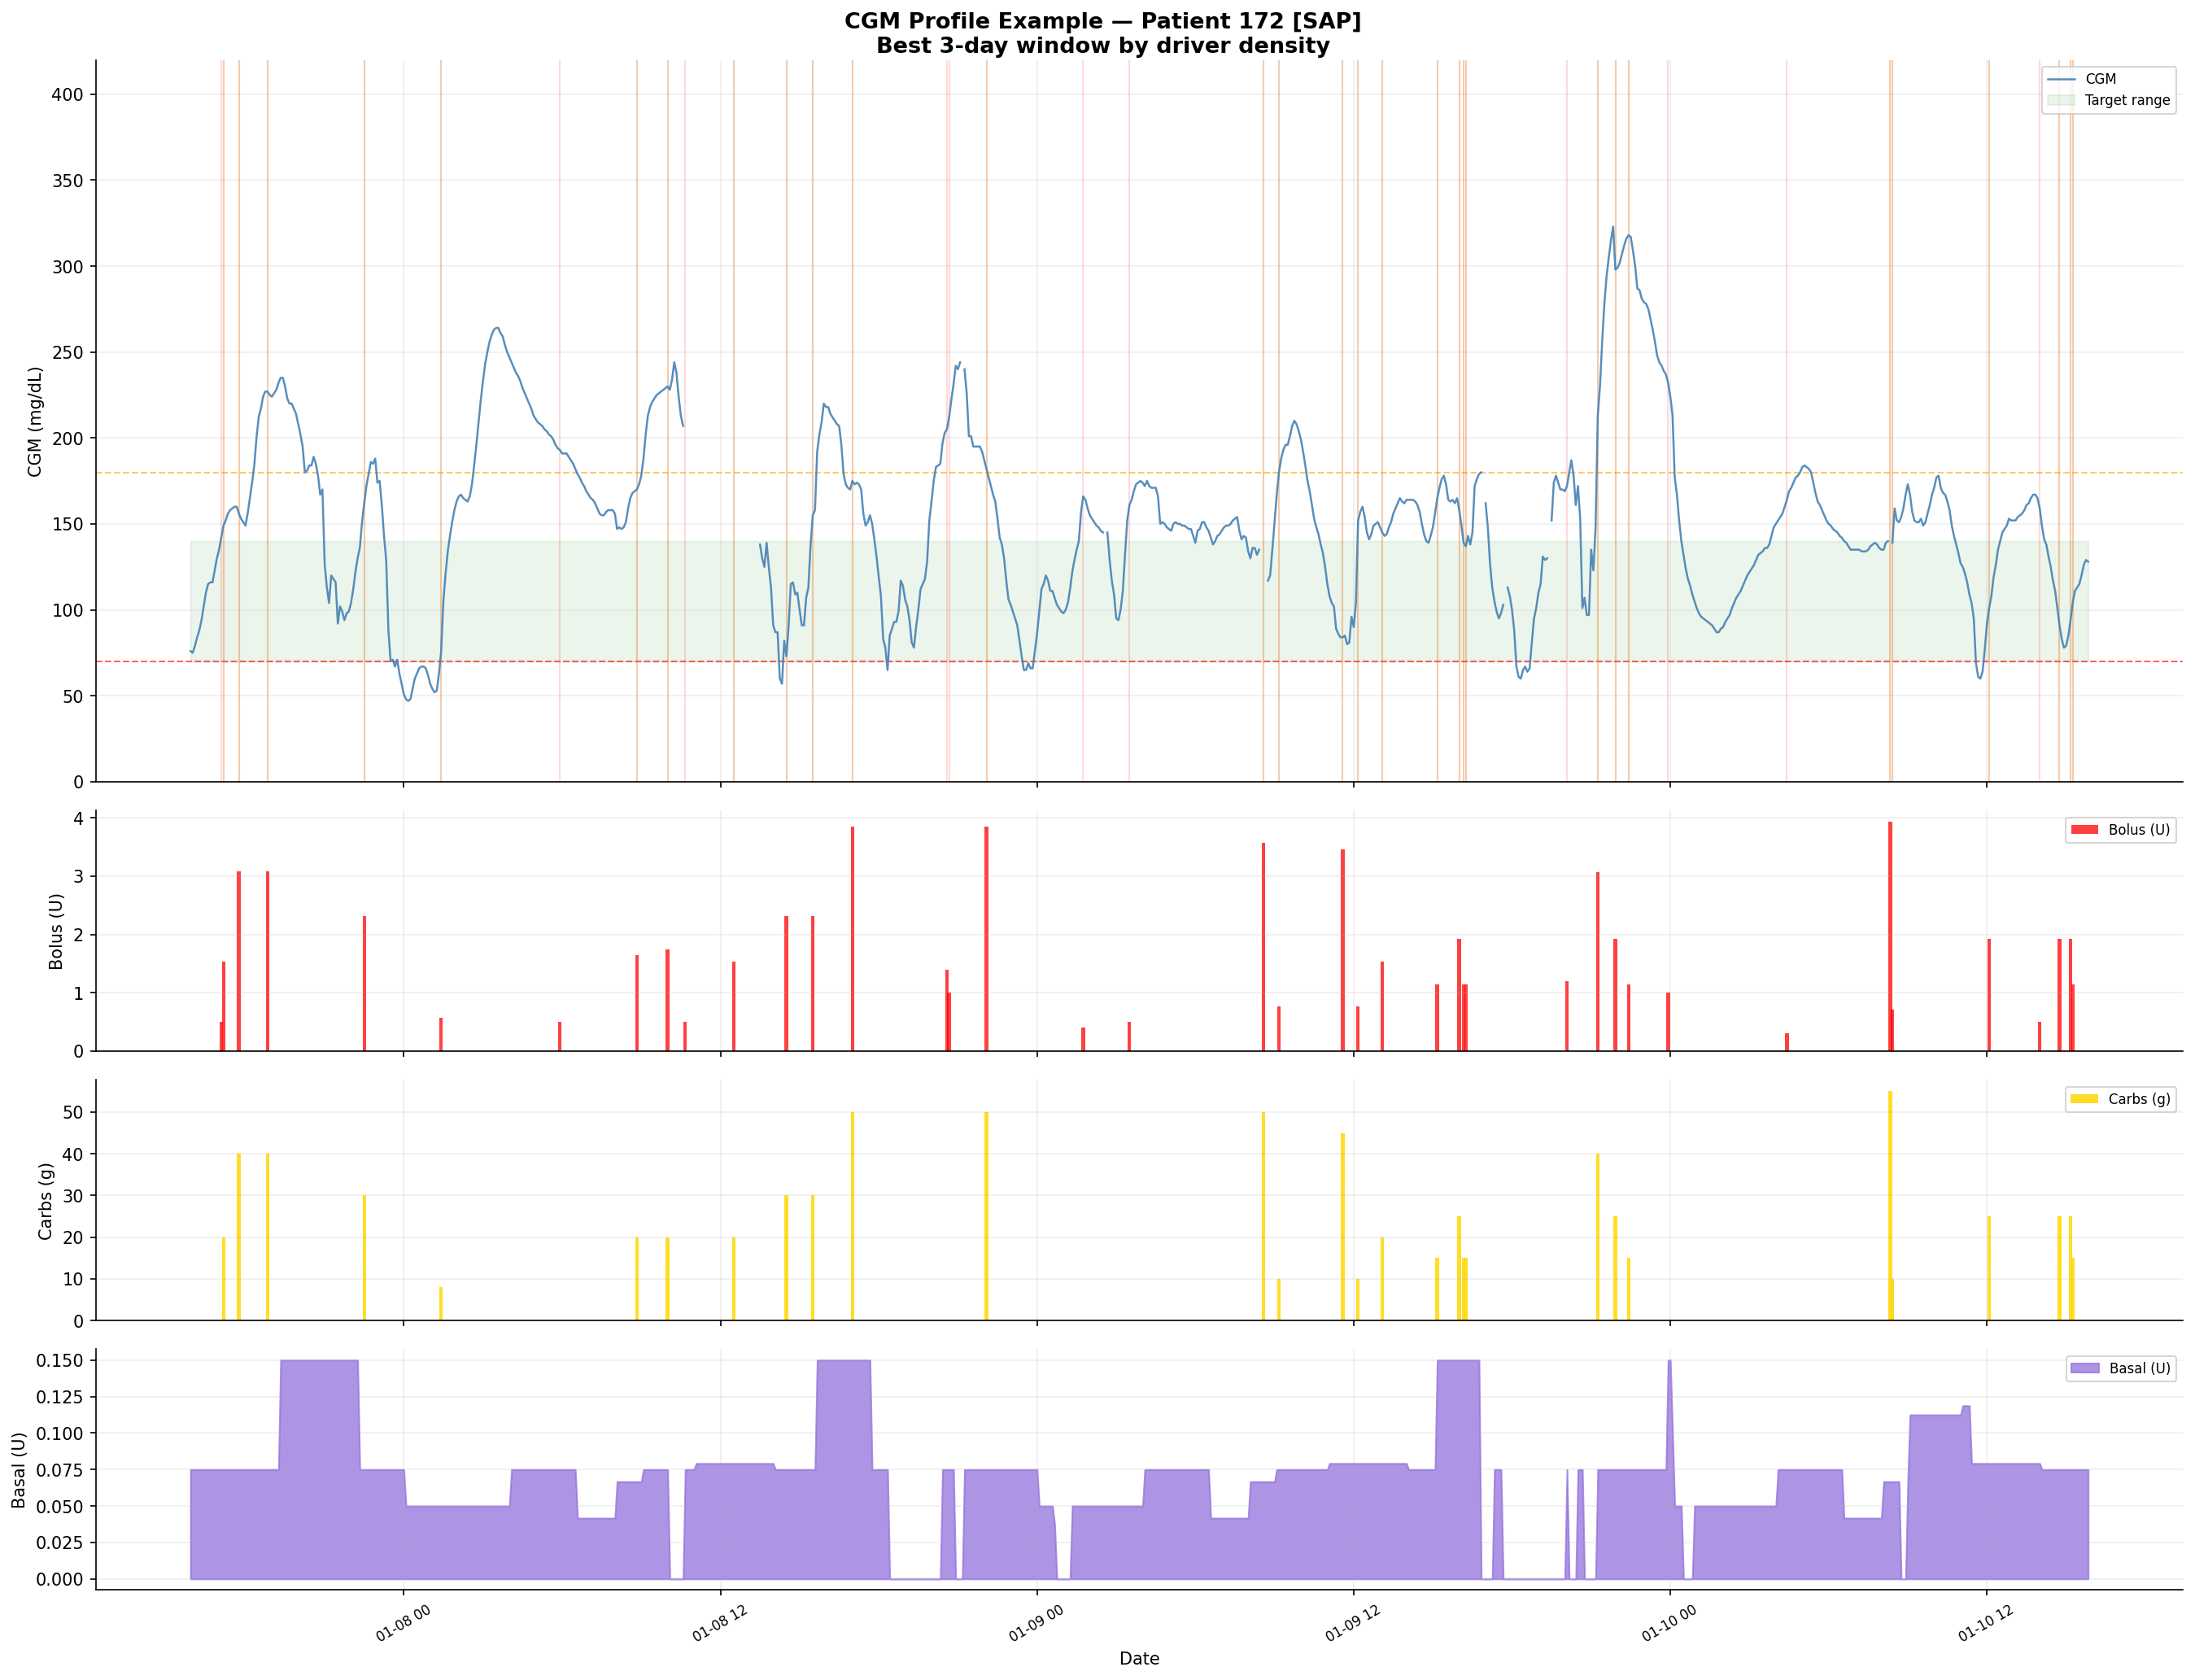

Saved: plots/09_cgm_profile_example.png


In [ ]:
# Cell 14 — CGM profile example: best patient with all drivers visible

# Find best SAP patient with good carbs
sap_valid = df_valid[df_valid['modality'] == 'SAP'].nlargest(1, 'carbs_per_day')
pid = str(sap_valid['id'].iloc[0])
print(f"Selected patient: {pid} (SAP, {sap_valid['carbs_per_day'].iloc[0]:.1f} carbs/day)")

# Load patient data
patient_chunks = []
f = pq.ParquetFile('raw_data/metabonet_train_filtered.parquet')
for batch in f.iter_batches(
        columns=['id', 'date', 'CGM', 'bolus', 'basal', 'carbs'],
        batch_size=1_000_000):
    df = batch.to_pandas()
    chunk = df[df['id'].astype(str) == pid]
    if len(chunk) > 0:
        patient_chunks.append(chunk)

df_p = pd.concat(patient_chunks).sort_values('date').reset_index(drop=True)
df_p['date'] = pd.to_datetime(df_p['date'])

# Find 3-day window with most carb events
def find_best_window(df_p, window_days=3):
    window_steps = window_days * 288
    stride       = 288
    best_start, best_score = 0, -1
    for start in range(0, len(df_p) - window_steps + 1, stride):
        window = df_p.iloc[start:start + window_steps]
        score  = (window['bolus'] > 0).sum() + \
                 3 * (window['carbs'] > 0).sum()
        if score > best_score:
            best_score = score
            best_start = start
    return df_p.iloc[best_start:best_start + window_steps]

df_zoom    = find_best_window(df_p, window_days=3)
bolus_mask = df_zoom['bolus'] > 0
carb_mask  = df_zoom['carbs'] > 0

fig, axes = plt.subplots(4, 1, figsize=(18, 14),
                          gridspec_kw={'height_ratios': [3, 1, 1, 1]},
                          sharex=True)
fig.suptitle(f"CGM Profile Example — Patient {pid} [SAP]\n"
             f"Best 3-day window by driver density",
             fontsize=13, fontweight='bold')

# Panel 1: CGM
ax = axes[0]
ax.plot(df_zoom['date'], df_zoom['CGM'],
        color='steelblue', lw=1.2, alpha=0.9, label='CGM', zorder=3)
ax.fill_between(df_zoom['date'], TARGET_LOW, TARGET_HIGH,
                alpha=0.08, color='green', label='Target range')
ax.axhline(HYPO_THRESHOLD,  color='red',    linestyle='--', lw=1, alpha=0.6)
ax.axhline(HYPER_THRESHOLD, color='orange', linestyle='--', lw=1, alpha=0.6)
for _, row in df_zoom[bolus_mask].iterrows():
    ax.axvline(row['date'], color='red',      alpha=0.15, lw=1)
for _, row in df_zoom[carb_mask].iterrows():
    ax.axvline(row['date'], color='goldenrod', alpha=0.25, lw=1)
ax.set_ylabel('CGM (mg/dL)')
ax.set_ylim(0, 420)
ax.legend(fontsize=8, loc='upper right')
ax.grid(alpha=0.2)

# Panel 2: bolus
ax = axes[1]
ax.bar(df_zoom.loc[bolus_mask, 'date'],
       df_zoom.loc[bolus_mask, 'bolus'],
       color='red', alpha=0.75,
       width=pd.Timedelta(minutes=8),
       label='Bolus (U)')
ax.set_ylabel('Bolus (U)')
ax.legend(fontsize=8, loc='upper right')
ax.grid(alpha=0.2)

# Panel 3: carbs
ax = axes[2]
ax.bar(df_zoom.loc[carb_mask, 'date'],
       df_zoom.loc[carb_mask, 'carbs'],
       color='gold', alpha=0.85,
       width=pd.Timedelta(minutes=8),
       label='Carbs (g)')
ax.set_ylabel('Carbs (g)')
ax.legend(fontsize=8, loc='upper right')
ax.grid(alpha=0.2)

# Panel 4: basal
ax = axes[3]
ax.fill_between(df_zoom['date'],
                0, df_zoom['basal'].fillna(0),
                color='mediumpurple', alpha=0.75,
                label='Basal (U)')
ax.set_ylabel('Basal (U)')
ax.set_xlabel('Date')
ax.legend(fontsize=8, loc='upper right')
ax.tick_params(axis='x', rotation=30, labelsize=8)
ax.grid(alpha=0.2)

plt.tight_layout()
plt.savefig('plots/09_cgm_profile_example.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: plots/09_cgm_profile_example.png")

In [18]:
"""
Cell 10 — Unannotated Postprandial Events
==========================================
Detects windows where CGM shows a postprandial-like rise (>30 mg/dL in 30 min)
but no carbs or bolus were logged. High ratio = poor annotation quality.
Used to identify and potentially exclude low-quality patients.
"""

import pyarrow.parquet as pq

# ── Config ────────────────────────────────────────────────────────────────────
PARQUET_PATH   = 'raw_data/metabonet_train_filtered.parquet'
CGM_RISE_MGDL  = 30
WINDOW_STEPS   = 6
EXCL_THRESHOLD = 0.75

# ── Per-patient postprandial detection via streaming ──────────────────────────
print("Detecting postprandial-like events per patient...")

pf = pq.ParquetFile(PARQUET_PATH)
patient_buffer = {}  # acumula filas por paciente

def process_patient(pid, pat_df):
    pat_df = pat_df.sort_values("date")
    cgm   = pat_df["CGM"].to_numpy()
    bolus = pat_df["bolus"].fillna(0).to_numpy()
    carbs = pat_df["carbs"].fillna(0).to_numpy()
    n     = len(cgm)

    if n <= WINDOW_STEPS:
        return None

    # Vectorized rise detection
    rise         = cgm[WINDOW_STEPS:] - cgm[:n - WINDOW_STEPS]
    valid        = ~np.isnan(cgm[:n - WINDOW_STEPS]) & ~np.isnan(cgm[WINDOW_STEPS:])
    is_pp        = valid & (rise >= CGM_RISE_MGDL)

    # Cumsum trick for window annotation check
    has_event    = ((carbs > 0) | (bolus > 0)).astype(float)
    cum          = np.concatenate([[0], np.cumsum(has_event)])
    window_sum   = cum[WINDOW_STEPS:n] - cum[:n - WINDOW_STEPS]
    is_annotated = window_sum > 0

    pp_total       = int(is_pp.sum())
    pp_unannotated = int((is_pp & ~is_annotated).sum())
    ratio          = pp_unannotated / pp_total if pp_total > 0 else np.nan

    return {"id": pid, "pp_total": pp_total, "pp_unannotated": pp_unannotated, "ratio": ratio}

results = []

for batch in pf.iter_batches(batch_size=500_000, columns=["id", "date", "CGM", "bolus", "carbs"]):
    batch_df = batch.to_pandas()
    
    for pid, pat in batch_df.groupby("id"):
        if pid in patient_buffer:
            patient_buffer[pid] = pd.concat([patient_buffer[pid], pat])
        else:
            patient_buffer[pid] = pat

# Process all patients once fully accumulated
for pid, pat_df in patient_buffer.items():
    result = process_patient(pid, pat_df)
    if result:
        results.append(result)

print(f"Processed {len(results)} patients")

res = pd.DataFrame(results).sort_values("ratio", ascending=False).reset_index(drop=True)

Detecting postprandial-like events per patient...
Processed 831 patients


In [19]:
# ── Summary statistics ────────────────────────────────────────────────────────
print("\n── Unannotated Postprandial Summary ──────────────────────────────")
print(f"Patients analysed:          {len(res)}")
print(f"Median postprandial events: {res['pp_total'].median():.0f}")
print(f"Median unannotated ratio:   {res['ratio'].median():.2%}")
print(f"Mean unannotated ratio:     {res['ratio'].mean():.2%}")
print(f"Patients ratio > {EXCL_THRESHOLD:.0%}:        "
      f"{(res['ratio'] > EXCL_THRESHOLD).sum()}")

flagged = res[res['ratio'] > EXCL_THRESHOLD]
print(f"\nFlagged for exclusion ({EXCL_THRESHOLD:.0%} threshold):")
print(flagged[["id", "pp_total", "pp_unannotated", "ratio"]].to_string(index=False))


── Unannotated Postprandial Summary ──────────────────────────────
Patients analysed:          831
Median postprandial events: 11045
Median unannotated ratio:   70.90%
Mean unannotated ratio:     69.82%
Patients ratio > 75%:        315

Flagged for exclusion (75% threshold):
  id  pp_total  pp_unannotated    ratio
 633     19669           19584 0.995678
 752     17023           16707 0.981437
 598      8481            8280 0.976300
 815      1274            1240 0.973312
 569      8727            8455 0.968832
1061     19932           19067 0.956602
 580      2687            2562 0.953480
1074      7232            6895 0.953402
 395      4132            3924 0.949661
 521      3758            3561 0.947578
1049      8741            8238 0.942455
 156      1961            1842 0.939317
1056      9829            9165 0.932445
 317     11580           10793 0.932038
2302       738             686 0.929539
 728     12474           11530 0.924323
2308      2725            2515 0.922936
 44

── Carb Events per Day ───────────────────────────────────────────
Patients analysed:                    831
Median events/day (days with carbs):  4.79
Mean events/day:                      5.08
Median % days with any carbs logged:  74.4%
Patients with <1 event/day median:    0
Patients with >=3 events/day median:  725
Patients with 0% days with carbs:     0


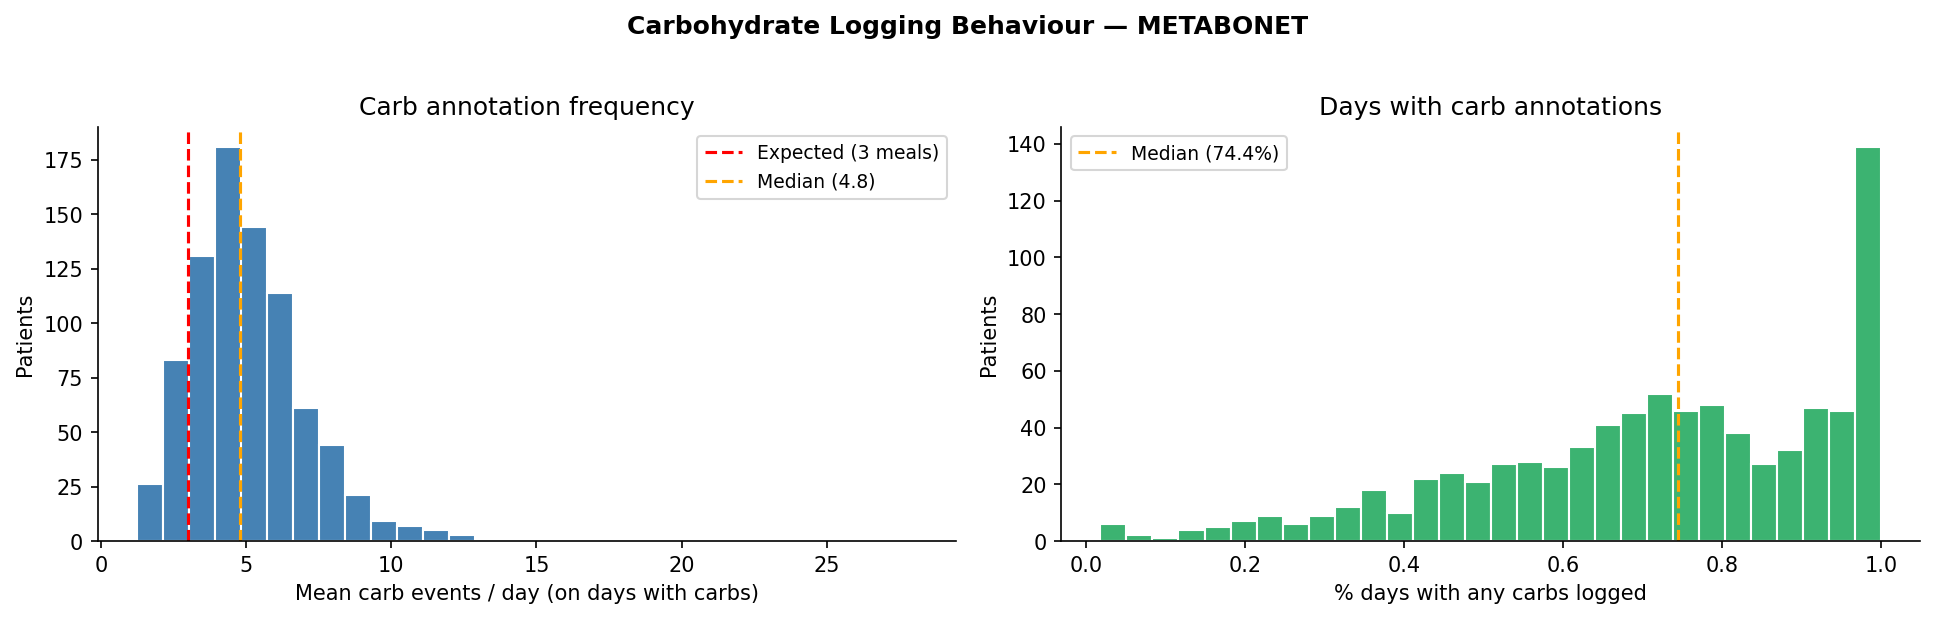

Saved: plots/10c_carbs_per_day.png


In [25]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

PARQUET_PATH = 'raw_data/metabonet_train_filtered.parquet'

# ── Load via streaming ────────────────────────────────────────────────────────
pf = pq.ParquetFile(PARQUET_PATH)
patient_buffer = {}

for batch in pf.iter_batches(batch_size=500_000, columns=["id", "date", "carbs"]):
    batch_df = batch.to_pandas()
    for pid, pat in batch_df.groupby("id"):
        if pid in patient_buffer:
            patient_buffer[pid] = pd.concat([patient_buffer[pid], pat])
        else:
            patient_buffer[pid] = pat

# ── Compute per-patient carb stats ────────────────────────────────────────────
carbs_events = []

for pid, pat in patient_buffer.items():
    pat = pat.copy()
    pat["date"] = pd.to_datetime(pat["date"])
    pat["day"] = pat["date"].dt.date
    
    daily = (
        pat[pat["carbs"] > 0]
        .groupby("day")
        .size()
        .reset_index(name="carb_events")
    )
    
    n_days = pat["day"].nunique()
    mean_events = daily["carb_events"].mean() if len(daily) > 0 else 0
    days_with_carbs = len(daily) / n_days if n_days > 0 else 0
    
    carbs_events.append({
        "id": pid,
        "n_days": n_days,
        "mean_carb_events_per_day": mean_events,
        "pct_days_with_carbs": days_with_carbs,
    })

carbs_df = pd.DataFrame(carbs_events).sort_values("mean_carb_events_per_day", ascending=False)

# ── Summary statistics ────────────────────────────────────────────────────────
print("── Carb Events per Day ───────────────────────────────────────────")
print(f"Patients analysed:                    {len(carbs_df)}")
print(f"Median events/day (days with carbs):  {carbs_df['mean_carb_events_per_day'].median():.2f}")
print(f"Mean events/day:                      {carbs_df['mean_carb_events_per_day'].mean():.2f}")
print(f"Median % days with any carbs logged:  {carbs_df['pct_days_with_carbs'].median():.1%}")
print(f"Patients with <1 event/day median:    {(carbs_df['mean_carb_events_per_day'] < 1).sum()}")
print(f"Patients with >=3 events/day median:  {(carbs_df['mean_carb_events_per_day'] >= 3).sum()}")
print(f"Patients with 0% days with carbs:     {(carbs_df['pct_days_with_carbs'] == 0).sum()}")

# ── Plot ──────────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

ax = axes[0]
ax.hist(carbs_df["mean_carb_events_per_day"], bins=30,
        color='steelblue', edgecolor='white')
ax.axvline(3, color='red', linestyle='--', linewidth=1.5, label='Expected (3 meals)')
ax.axvline(carbs_df["mean_carb_events_per_day"].median(),
           color='orange', linestyle='--', linewidth=1.5,
           label=f'Median ({carbs_df["mean_carb_events_per_day"].median():.1f})')
ax.set_xlabel("Mean carb events / day (on days with carbs)")
ax.set_ylabel("Patients")
ax.set_title("Carb annotation frequency")
ax.legend(fontsize=9)
ax.spines[['top', 'right']].set_visible(False)

ax = axes[1]
ax.hist(carbs_df["pct_days_with_carbs"], bins=30,
        color='mediumseagreen', edgecolor='white')
ax.axvline(carbs_df["pct_days_with_carbs"].median(),
           color='orange', linestyle='--', linewidth=1.5,
           label=f'Median ({carbs_df["pct_days_with_carbs"].median():.1%})')
ax.set_xlabel("% days with any carbs logged")
ax.set_ylabel("Patients")
ax.set_title("Days with carb annotations")
ax.legend(fontsize=9)
ax.spines[['top', 'right']].set_visible(False)

plt.suptitle("Carbohydrate Logging Behaviour — METABONET",
             fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig("plots/10c_carbs_per_day.png", dpi=150, bbox_inches='tight')
plt.show()
print("Saved: plots/10c_carbs_per_day.png")